In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from IPython.display import clear_output



In [2]:
earth_radius = 6378 #+ 670 # Adding athmosphere...

In [3]:
def mjd2gd(mjd):
    jd = mjd + 2400000.5
    jd=jd+0.5
    Z=int(jd)
    F=jd-Z
    alpha=int((Z-1867216.25)/36524.25)
    A=Z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int( (B-122.1)/365.25)
    D = int( 365.25*C )
    E = int( (B-D)/30.6001 )

    dd = B - D - int(30.6001*E) + F

    if E<13.5:
        mm=E-1

    if E>13.5:
        mm=E-13

    if mm>2.5:
        yyyy=C-4716

    if mm<2.5:
        yyyy=C-4715

    months=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    daylist=[31,28,31,30,31,30,31,31,30,31,30,31]
    daylist2=[31,29,31,30,31,30,31,31,30,31,30,31]

    h=int((dd-int(dd))*24)
    min=int((((dd-int(dd))*24)-h)*60)
    sec=86400*(dd-int(dd))-h*3600-min*60

    # Now calculate the fractional year. Do we have a leap year?
    if (yyyy%4 != 0):
        days=daylist2
    elif (yyyy%400 == 0):
        days=daylist2
    elif (yyyy%100 == 0):
        days=daylist
    else:
        days=daylist2

     
    return yyyy,mm,dd

def mjd2predict(mjd):
    import datetime
    yyyy,mm,dd = mjd2gd(mjd)
    t = datetime.datetime(yyyy,mm,int(dd))
    tt = t.timetuple()
    yday = tt.tm_yday
    yy = str(yyyy)[-2:]

    s = yy + "%03d" % (yday)
    return int(s) 

def get_tle(f,mjd,of="/Users/npirzkal/.predict/predict.tle"):

    date = mjd2predict(mjd)
    lines = open(f).readlines()
    mind = 1e32

    for i in range(len(lines)):
        l = lines[i]
        if l[0]=="1":
            ws = l.split()
            tdate = float(ws[3])
            dd = abs(tdate-date)
            if dd<mind:
                mind = dd
                l1 = lines[i]
                l2 = lines[i+1]
            #print tdate,abs(tdate-date)
    s = []
    s.append("HUBBLE\n")
    s.append(l1)
    s.append(l2)
    open(of,"w").writelines(s)

    s = "predict -u %s" % (of)
    print (s)
    
#get_tle("/user/npirzkal/tmp/sat20580.txt",57329.61743392)

In [4]:
def posang(rarad1,dcrad1,rarad2,dcrad2):
    d2r    = np.pi/180.0
    h2r    = np.pi/12.0
    
    radif  = rarad2-rarad1
    angle  = np.arctan2(np.sin(radif),np.cos(dcrad1)*np.tan(dcrad2)-np.sin(dcrad1)*np.cos(radif))
    return angle

def hstv1v2v3(RA_V1,DEC_V1,PA_V3):
    tiny = 0.01*np.pi/180.
    rr = RA_V1*np.pi/180.
    dd = DEC_V1*np.pi/180.
    pa = PA_V3*np.pi/180.
    
    rr3 = rr - np.arctan(np.tan(pa)/np.sin(dd))
    dd3 =    - np.arctan(np.cos(rr3-rr)/np.tan(dd))

    angle = posang(rr,dd,rr3,dd3)
    if angle<0: angle = angle + 2*np.pi
    if np.abs(pa-angle)>tiny:
        rr3 = rr3 + np.pi
        dd3 = -dd3
    angle = posang(rr,dd,rr3,dd3)
   
    if angle<0: angle = angle + 2*np.pi
    if np.abs(pa-angle)>tiny:
        print("something is not right here")
        print(np.abs(pa-angle),tiny)
        sys.exit(1)
    x1 = rd2xyz(180./np.pi*rr,180./np.pi*dd)
    x3 = rd2xyz(180./np.pi*rr3,180./np.pi*dd3)
    x2 = np.cross(x3,x1)
    rd = xyz2rd(x2)
    rr2 = rd[0]*np.pi/180.
    dd2 = rd[1]*np.pi/180.
    
    result = 180./np.pi*np.array([rr,dd,rr2,dd2,rr3,dd3])
    # Sanity check
    angle = posang(np.pi/180*result[0],np.pi/180*result[1],np.pi/180*result[4],np.pi/180*result[5])
    if angle<0: angle = angle + 2*np.pi
    if abs(pa-angle)>tiny:
        print("Something not right here 2")
        sys.exit(1)
    return result

def xyz2rd(xyz):
    l = (xyz[0]*xyz[0]+xyz[1]*xyz[1]+xyz[2]*xyz[2])**0.5
    dd  = 180./np.pi*np.arcsin(xyz[2]/l)
    rr  = 180./np.pi*np.arctan2(xyz[1],xyz[0])
    return [rr,dd]


def rd2xyz(r,d):
    rr = r*np.pi/180.
    dd = d*np.pi/180.
    
    x = np.array([np.cos(rr)*np.cos(dd),np.sin(rr)*np.cos(dd),np.sin(dd)])
    
    return np.transpose(x)


def ct2lst(lng,jd):
    c = [280.46061837, 360.98564736629, 0.000387933, 38710000.0 ]
    jd2000 = 2451545.0
    t0 = jd - jd2000
    t = t0/36525.
    theta = c[0] + (c[1] * t0) + t**2*(c[2] - t/ c[3] )
    lst = (theta + lng)/15.0

    if lst<0:
        lst = 24. + (lst % 24)

    lst = lst % 24.
    return lst
#hstv1v2v3( 53.173852,-27.784070,167.49760)
#xyz2rd([ 0.72099204 ,-0.66595012, -0.1915226 ])

In [5]:
import tempfile
output = tempfile.mktemp(dir="/tmp/")

print("sig")

sig


In [6]:
def hst_geocentric(obs_id):
    import os, tempfile
    from astropy.io import fits
    import astropy
    #if os.path.isfile("{}.earth".format(obs_id)):
    #    return None
    raw = "{}_raw.fits".format(obs_id)
#     spt = "{}_spt.fits".format(obs_id)
    
    if not os.path.isfile(raw):
        print("{} missing...".format(raw))
        return

    with fits.open(raw) as fin:
        h1 = fin[0].header
        h2 = fin[2].header
        ra_v1 = h2["CRVAL1"]
        dec_v1 = h2["CRVAL2"]
        pa_v3 = h1["PA_V3"]
        expstart = h1["EXPSTART"]
        exptime = h1["EXPTIME"]
        nsamp = h1["NSAMP"]
            
    p_hst =  96./60./24. # period of HST in days
    h_hst =  562. # km (checked this value)
    r_e   = earth_radius # km (checked this value)
    theta = np.arcsin(r_e / (r_e + h_hst))
    rot_uv  = (270.+22.) * np.pi/180. # rotation angle in V2-V3 plane of UV Vent tube from +V2 axis toward +V3.
    rot_ir  = (270.-22.) * np.pi/180. # rotation angle in V2-V3 plane of IR Vent tube from +V2 axis toward +V3.
    cadence = 60.

    jd = expstart + exptime/2./86400. - p_hst/2 + np.arange(0,int(p_hst*86400./cadence))*cadence/86400.

    jdexpstart = expstart
    jdexpstop  = expstart + exptime/86400.
    
    dJD = 0.5 + 2400000
    sec_start = int((np.min(jd+dJD)-2440587.5)*86400.)
    sec_end = int((np.max(jd+dJD)-2440587.5)*86400.)
    
    v1v2v3 = hstv1v2v3(ra_v1,dec_v1,pa_v3)
    
    # update the tle 
    get_tle("/Users/npirzkal/Dropbox/predict/sat20580.txt",jd[0])
    output = tempfile.mktemp(dir="/tmp/")
    cmd = "predict -east -f HUBBLE {} {} > {}".format(sec_start,sec_end,output)
    #print(cmd)
    from astropy.table import Table
    os.system(cmd)
    lines = open(output).readlines()
    os.unlink(output)
    lon = np.array([float(x.split()[8]) for x in lines])
    lat = np.array([float(x.split()[7]) for x in lines])

    from scipy.interpolate import interp1d
    jd_predict = np.min(jd+dJD)+np.arange(len(lon))*1./86400
    flon = interp1d(jd_predict,lon,bounds_error=False)
    lon = np.array([flon(x) for x in jd+dJD])
    flat = interp1d(jd_predict,lat,bounds_error=False)
    lat = np.array([flat(x) for x in jd+dJD])
    
    from astropy.time import Time
    from astropy.coordinates import solar_system_ephemeris, EarthLocation
    from astropy.coordinates import get_body_barycentric, get_body, get_moon

    sunpos = np.array([get_body('sun', Time(t+dJD,format="jd")) for t in jd])

    ra_sun = np.array([x.ra.deg for x in sunpos])
    dec_sun = np.array([x.dec.deg for x in sunpos])
    gst = np.array([ct2lst(0.,t+dJD) for t in jd])
    
    ra_hst = lon + gst*15
    dec_hst = lat

    x_hst = rd2xyz(ra_hst,dec_hst)
    x_sun = rd2xyz(ra_sun,dec_sun)
    x_1   = rd2xyz(v1v2v3[0],v1v2v3[1])  # X_1 <= RA_V1, DEC_V1
    x_2   = rd2xyz(v1v2v3[2],v1v2v3[3])  # X_2 <= RA_V2, DEC_V2
    x_3   = rd2xyz(v1v2v3[4],v1v2v3[5])  # X_3 <= RA_V3, DEC_V3
    
    sb = np.zeros((len(x_hst),3))
    for j in range(3):
        if j==0: x_v = x_1
        if j==1: x_v = np.cos(rot_uv)*x_2 + np.sin(rot_uv)*x_3
        if j==2: x_v = np.cos(rot_ir)*x_2 + np.sin(rot_ir)*x_3 
        
        alpha = np.arccos(np.dot(-x_hst,x_v))
        alpha = np.arccos(np.dot(x_hst,x_v))


        beta  = np.pi - np.arcsin((r_e + h_hst) * np.sin(alpha)/r_e)

        gamma = np.pi - (alpha + beta)
        L     = np.sin(gamma) / np.sin(alpha) * r_e
        x_intercept = np.array([(x_hst[i]*(r_e+h_hst) + x_v*L[i]) / r_e for i in range(len(x_hst))])
        dp = np.array([np.dot(x_sun[i],x_intercept[i]) for i in range(len(x_intercept))])
        thr = 0.03
        if j==0:
            print("alpha:",alpha,theta)
        ok = dp>thr
        sb[:,j][ok] = dp[ok]
        tmp = thr*np.exp((dp-thr)*30.)

        tmp[tmp<0.001] = 0.001
        sb[:,j][~ok] = tmp[~ok]
        
        
        ok = alpha>=theta
        sb[:,j][ok]=0.
        
    # temp
    #    sb[:,j]=alpha

#     x_hst = rd2xyz(RA_HST,DEC_HST)
#     x_sun = rd2xyz(RA_SUN,DEC_SUN)
#     x_1 = rd2xyz(RA_V1,DEC_V1)
#     x_2 = rd2xyz(RA_V2,DEC_V2)
#     x_3 = rd2xyz(RA_V3,DEC_V3)
    
    theta = np.arcsin(r_e / (r_e + h_hst))   #angular semi-diameter of Earth viewed from HST
    tmp = [np.dot(-x_hst[i],x_1) for i in range(len(x_hst))]
    r = 180./np.pi*(np.arccos(tmp) - theta) # Earth Limb Angle from V1
    
    tmp = [np.dot(-x_hst[i],x_3) for i in range(len(x_hst))]
    r3 = 180./np.pi*(np.arccos(tmp) - theta) # Earth Limb Angle from V3
    
    

    sb_tl = thr
    print("HERE")
    dp1   = np.cos((90.+18.)*np.pi/180.)


    dp = np.array([np.dot(x_hst[i],x_sun[i]) for i in range(len(x_hst))])
    
    print("dp:",dp)
    z = np.zeros(len(dp),float)
    z[dp>sb_tl] = 1.
    z[(dp<sb_tl) & (dp>dp1)] = 0.5

    
    istart = np.min(np.nonzero(jd>=jdexpstart))
    iend = np.max(np.nonzero(jd<=jdexpstop))
    s = []
    head = "# JD YEAR MONTH DAY HOUR MIN SEC HST_LON HST_LAT RA_HST DEC_HST RA_V1 DEC_V1 RA_V2 DEC_V2 RA_V3 DEC_V3 RA_SUN DEC_SUN LIMBANG LIMBANG3 SB_V1 SB_UV SB_IR BRIGHT\n"
    s.append(head)
    for i in range(len(jd)):
        if i==istart:
            tmp = astropy.time.Time(jdexpstart+dJD, format='jd').datetime
            dystr = "%d %d %d %d %d %d" % (tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute,tmp.second)
            ss = "# %7.5f  %s START NSAMP  %d %f sec exposure.\n" % (jdexpstart+dJD,dystr,nsamp,exptime)
            s.append(ss)
        if i==iend:
            tmp = astropy.time.Time(jdexpstop+dJD, format='jd').datetime
            dystr = "%d %d %d %d %d %d" % (tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute,tmp.second)
            ss = "# %7.5f  %s STOP NSAMP  %d %f sec exposure.\n" % (jdexpstop+dJD,dystr,nsamp,exptime)
            s.append(ss)
        tmp = astropy.time.Time(jd[i]+dJD, format='jd').datetime
        dystr = "%d %d %d %d %d %d" % (tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute,tmp.second)
        vstr = "%3.2f %3.2f %3.2f %3.2f %3.2f %3.2f" % (v1v2v3[0],v1v2v3[1],v1v2v3[2],v1v2v3[3],v1v2v3[4],v1v2v3[5])
        ss = "%7.5f %s %3.2f %3.2f %3.2f %3.2f %s %3.2f  %3.2f %3.2f %3.2f  %3.2f %3.2f %3.2f %2.1f\n" % (jd[i]+dJD,dystr,lon[i]%360,lat[i],ra_hst[i]%360,dec_hst[i],vstr,ra_sun[i]%360,dec_sun[i],r[i],r3[i],sb[i,0],sb[i,1],sb[i,2],z[i])
        
        s.append(ss)
    print("sb:",sb)
    open("{}.earth".format(obs_id),"w").writelines(s)
    return jd

earth_radius = 6378 + 670 # Adding athmosphere... #+ 670 # Adding athmosphere...


obsid = "ib8cbrepq"
get_data(obsid)
jd=hst_geocentric(obsid)
plot(obsid)

# obsid="ib8c5mh6q"
# get_data(obsid)
# jd=hst_geocentric(obsid)


NameError: name 'get_data' is not defined

In [7]:
def plot(obsid):
    lines = open("{}.earth".format(obsid)).readlines()

    res = []
    start = 0
    stop = 0
    for l in lines[1:]:
        if "START" in l:
            jdstart = float(l.split()[1])
            continue
        if "STOP" in l:
            jdstop = float(l.split()[1])
            continue
        ws = [float(x) for x in l.strip().split()]
        if len(ws)>20:
            res.append(ws)

    jd ,  Year, MM, DD, HH, MM, SS, LON_HST, LAT_HST , RA_HST, DEC_HST ,  RA_V1 , DEC_V1 ,  RA_V2 , DEC_V2 ,  RA_V3 , DEC_V3 , RA_SUN, DEC_SUN, LIMBANG, LIMBANG3, SB_V1, SB_UV, SB_IR, BRIGHT = np.transpose(np.array(res))

    x_hst = rd2xyz(RA_HST,DEC_HST)
    x_sun = rd2xyz(RA_SUN,DEC_SUN)
    x_1 = rd2xyz(RA_V1,DEC_V1)
    x_2 = rd2xyz(RA_V2,DEC_V2)
    x_3 = rd2xyz(RA_V3,DEC_V3)

    h_hst =  562. # km (checked this value)
    r_e   = earth_radius # km (checked this value)

    r = LIMBANG 
    r3 = LIMBANG3
    
    
    sb_tl = 0.03
    dp1   = np.cos((90.+18.)*np.pi/180.)

    #dp  = np.dot(x_hst,x_sun.T)
    jd0   = int(min(jd)/1000.)*1000.

    z = BRIGHT

    #oplot,jd-jd0,dec_hst,line=1,col=c24(14)
    plt.rcParams["figure.figsize"] = (15,7)
    plt.rcParams["axes.formatter.useoffset"] = False
    #plt.plot(jd-jd0,r)

    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    ax.scatter((jd-jd0)[z==0],r[z==0],c='g',label="Dark")
    ax.scatter((jd-jd0)[z==0.5],r[z==0.5],c='C1',label="Twilight")
    ax.scatter((jd-jd0)[z==1],r[z==1],c='C3',label="Bright")

    ax.plot((jd-jd0),r3,c='C5')
    ax.plot((jd-jd0),r,c='C5')




    ax.axvspan(jdstart-jd0,jdstop-jd0,color='g',alpha=0.25)
    ax.set_ylim(np.nanmin(r),np.nanmax(r))
    ax.set_ylim(-100,100)
    ax.axhline(0,color='k')

    #oplot,[jd[k],jd[k]]-jd0,[dec_hst[k],dec_hst[k]];;;;;,psy=8,col=c24(14)
    ax.plot(jd-jd0,DEC_HST,ls="dotted",label="HST lat (deg)")
    ax.set_ylabel("V1 LOS Limb Angle (deg)")
    ax.set_xlabel("JD - {}".format(jd0))
    ax.set_xlim(np.min(jd-jd0),np.max(jd-jd0))

    ax.legend(loc=4)

#     t = find_jitter(obsid)
#     x = t["Seconds"]/86400 + jdstart-jd0 
#     #print(x)
#     ax.plot(x,t["LimbAng"],lw=4,color='g')
#     bright = t["BrightLimb"]>0
#     ax.plot(x[bright],t["LimbAng"][bright],lw=4,color='r')
    



    ax2 = ax.twinx()
    ax2.scatter(jd[SB_V1>0]-jd0,SB_V1[SB_V1>0]*100,marker="+",color='g',label="Brightness (%) V1")
    ax2.scatter(jd[SB_IR>0]-jd0,SB_IR[SB_IR>0]*100,marker="+",color='r',label="Brightness (%)IR vent")
    ax2.scatter(jd[SB_UV>0]-jd0,SB_UV[SB_UV>0]*100,marker="+",color='b',label="Brightness (%)UV vent")
    ax2.set_ylim(-100,100)
    ax2.set_ylabel("Brightness (%)")

    ax2.legend(loc=3)
    ax.set_title(obsid)
    plt.savefig("{}.earth.png".format(obsid))


In [8]:
def add_axes_at(fig,ax, x,y,w,h):
    """Adds an axes instance at a certain coordinate in the plot."""
    import matplotlib
    Bbox = matplotlib.transforms.Bbox.from_bounds(x, y, w, h)
    trans = ax.transAxes + fig.transFigure.inverted()
    x1, y1, w1, h1 = matplotlib.transforms.TransformedBbox(Bbox, trans).bounds
    print("Transformed into 0,1 coordinates:")
    print("\t",x,"=>", x1);
    print("\t",y,"=>", y1);
    print("\t",w,"=>", w1);
    print("\t",h,"=>", h1);
    axins = fig.add_axes([x1, y1, w1, h1])
    return axins

def plot2(obsid):
    from astropy.io import fits
    lines = open("{}.earth".format(obsid)).readlines()

    res = []
    start = 0
    stop = 0
    for l in lines[1:]:
        if "START" in l:
            jdstart = float(l.split()[0])
            continue
        if "STOP" in l:
            jdstop = float(l.split()[0])
            continue
        ws = [float(x) for x in l.strip().split()]
        if len(ws)>20:
            res.append(ws)

    jd ,  Year, MM, DD, HH, MM, SS, LON_HST, LAT_HST , RA_HST, DEC_HST ,  RA_V1 , DEC_V1 ,  RA_V2 , DEC_V2 ,  RA_V3 , DEC_V3 , RA_SUN, DEC_SUN, SB_V1, SB_UV, SB_IR = np.transpose(np.array(res))

    x_hst = rd2xyz(RA_HST,DEC_HST)
    x_sun = rd2xyz(RA_SUN,DEC_SUN)
    x_1 = rd2xyz(RA_V1,DEC_V1)
    x_2 = rd2xyz(RA_V2,DEC_V2)
    x_3 = rd2xyz(RA_V3,DEC_V3)

    h_hst =  562. # km (checked this value)
    r_e   = earth_radius # km (checked this value)
    theta = np.arcsin(r_e / (r_e + h_hst))   #angular semi-diameter of Earth viewed from HST

    tmp = [np.dot(-x_hst[i],x_1[i]) for i in range(len(x_1))]

    r = 180./np.pi*(np.arccos(tmp) - theta)

    sb_tl = 0.03
    dp1   = np.cos((90.+18.)*np.pi/180.)

    #dp  = np.dot(x_hst,x_sun.T)
    jd0   = int(min(jd)/1000.)*1000.

    sb_tl = 0.03
    v = SB_V1*0.
    v[SB_V1==0] = 0.
    v[(SB_V1>0) & ((SB_V1<=sb_tl))] = 0.5
    v[SB_V1>sb_tl] = 1.

    dp = np.array([np.dot(x_hst[i],x_sun[i]) for i in range(len(x_hst))])
    z = SB_V1*0.
    z[dp>sb_tl] = 1.
    z[(dp<sb_tl) & (dp>dp1)] = 0.5


    #oplot,jd-jd0,dec_hst,line=1,col=c24(14)
    plt.rcParams["figure.figsize"] = (15,7)
    plt.rcParams["axes.formatter.useoffset"] = False
    #plt.plot(jd-jd0,r)

    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    ax.scatter((jd-jd0)[z==0],r[z==0],c='g',label="Dark")
    ax.scatter((jd-jd0)[z==0.5],r[z==0.5],c='C1',label="Twilight")
    ax.scatter((jd-jd0)[z==1],r[z==1],c='C3',label="Bright")


    ax.axvspan(jdstart-jd0,jdstop-jd0,color='g',alpha=0.25,ymin=0.5,ymax=1)
    ax.set_ylim(np.nanmin(r),np.nanmax(r))
    ax.set_ylim(-100,100)
    ax.axhline(0,color='k')

    #oplot,[jd[k],jd[k]]-jd0,[dec_hst[k],dec_hst[k]];;;;;,psy=8,col=c24(14)
    ax.plot(jd-jd0,DEC_HST,ls="dotted",label="HST lat (deg)")
    ax.set_ylabel("V1 LOS Limb Angle (deg)")
    ax.set_xlabel("JD - {}".format(jd0))
    ax.set_xlim(np.min(jd-jd0),np.max(jd-jd0))

    ax.legend(loc=3)
    dJD = 0.5 + 2400000
    axis = plt.axis()
    print("axes:",axis)
    #axes: (460.85026999982074, 460.9155500000343, -100.0, 100.0)
    print(jdstart-jd0,jdstop-jd0)
    x = ((jdstart-jd0)-axis[0])/(axis[1]-axis[0])
    w = (jdstop-jdstart)/(axis[1]-axis[0])
    print(x,w)
   # (jdstart-jd0-dJD)
    ins = add_axes_at(fig,ax,x,0.1,w,0.3)
    ins.set_xlim(jdstart-jd0,jdstop-jd0)
    
    ax2 = ax.twinx()
    ax2.scatter(jd[SB_V1>0]-jd0,SB_V1[SB_V1>0]*100,marker="+",color='g',label="Brightness (%) V1")
    ax2.scatter(jd[SB_IR>0]-jd0,SB_IR[SB_IR>0]*100,marker="+",color='r',label="Brightness (%)IR vent")
    ax2.scatter(jd[SB_UV>0]-jd0,SB_UV[SB_UV>0]*100,marker="+",color='b',label="Brightness (%)UV vent")
    ax2.set_ylim(-100,100)
    ax2.set_ylabel("Brightness (%)")

    ax2.legend(loc=1)
    ax.set_title(obsid)

    ima = "{}_ima.fits".format(os.path.join(os.path.split(f)[0],os.path.split(f)[-1][0:9]))
    with fits.open(ima) as fin:
        nsamp = fin[0].header["NSAMP"]
        for i in range(1,nsamp):
            h = fin["SCI",i].header
            hei = h["HEI_{}".format(i)]
            scat = h["SCAT_{}".format(i)]
            t = h["ROUTTIME"]
            print(i,t,jd0,hei,scat)
            ax.axvline(t+dJD-jd0,ymin=0.5,ymax=1,color="w")
            if i==1:
                ins.scatter(t+dJD-jd0,hei,marker='*',color="k",label="HeI")
                ins.scatter(t+dJD-jd0,scat,marker='x',color="k",label="Scat")
            else:
                ins.scatter(t+dJD-jd0,hei,marker='*',color="k")
                ins.scatter(t+dJD-jd0,scat,marker='x',color="k")
    ins.set_ylabel("e-/s")
    ins.legend()
    
    plt.savefig("{}.earth2.png".format(obsid))



In [9]:
def get_data(obs_id,path="./",CRCORR="perform",FLATCORR="perform"):
    import os
    
    url = "https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/{}_raw.fits".format(obs_id)

    import urllib,shutil

    
    tmpfile = os.path.join(path,"{}_raw.fits".format(obs_id))
    if not os.path.isfile(tmpfile):
        with urllib.request.urlopen(url) as response, open(tmpfile, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        #print(tmpfile)
        


In [10]:
def find_jitter(obsid):
    import glob
    from astropy.io import fits
    files = glob.glob("/Volumes/Data/WFC3/jit/{}*_jit.fits".format(obsid[0:6]))
    print(files)
    if len(files)>1:
        print("There can be only One...")
        return
    f = files[0]
    with fits.open(f) as fin:
        for i in range(1,len(fin)):
            h = fin[i].header["EXPNAME"]
            if h[0:8]==obsid[0:8]:
                print(i,h)            
                tab = Table.read(f,hdu=i)#fin[i].data
    return tab

    


In [19]:

import glob, os, tqdm, shutil
missing = []
files = glob.glob("/Volumes/Data/GXXX_Back/G102_procV12_superclean/*_flt.fits")
for f in tqdm.tqdm_notebook(files):
    obsid = os.path.split(f)[-1][0:9]
    if os.path.isfile("/Volumes/Data/GXXX_Back/G102_procV12_superclean/{}.earth.png".format(obsid)):
       # print(obsid,"done")
        continue
    jit = "/Volumes/Data/WFC3/jit/{}??[0j]_jit.fits".format(obsid[0:6])
    if len(glob.glob(jit))==0:
        print(obsid,jit,"missing")
        missing.append(jit)
        continue
    get_data(obsid)
    jd=hst_geocentric(obsid)
    plot(obsid)
    raw = "{}_raw.fits".format(obsid)
    os.unlink(raw)
    shutil.move("{}.earth.png".format(obsid),"/Volumes/Data/GXXX_Back/G102_procV12_superclean/{}.earth.png".format(obsid))
    shutil.move("{}.earth".format(obsid),"/Volumes/Data/GXXX_Back/G102_procV12_superclean/{}.earth".format(obsid))

    
   

idlk01jmq /Volumes/Data/WFC3/jit/idlk01??[0j]_jit.fits missing
idlk01joq /Volumes/Data/WFC3/jit/idlk01??[0j]_jit.fits missing
idlk01jpq /Volumes/Data/WFC3/jit/idlk01??[0j]_jit.fits missing
idlk01jrq /Volumes/Data/WFC3/jit/idlk01??[0j]_jit.fits missing
idlk03b2q /Volumes/Data/WFC3/jit/idlk03??[0j]_jit.fits missing
idlk03b4q /Volumes/Data/WFC3/jit/idlk03??[0j]_jit.fits missing
idlk03b5q /Volumes/Data/WFC3/jit/idlk03??[0j]_jit.fits missing
idlk03b7q /Volumes/Data/WFC3/jit/idlk03??[0j]_jit.fits missing
idwbk3z1q /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk3z3q /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk3z4q /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk3z7q /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk3z9q /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk3zaq /Volumes/Data/WFC3/jit/idwbk3??[0j]_jit.fits missing
idwbk5lvq /Volumes/Data/WFC3/jit/idwbk5??[0j]_jit.fits missing
idwbk5lxq /Volumes/Data/WFC3/jit/idwbk5??[0j]_jit.fits 

2788 of 3559
2789 of 3559
2790 of 3559
2791 of 3559
2792 of 3559
2793 of 3559
2794 of 3559
2795 of 3559
2796 of 3559
2797 of 3559
2798 of 3559
2799 of 3559
2800 of 3559
2801 of 3559
2802 of 3559
2803 of 3559
2804 of 3559
2805 of 3559
2806 of 3559
2807 of 3559
2808 of 3559
2809 of 3559
2810 of 3559
2811 of 3559
2812 of 3559
2813 of 3559
2814 of 3559
2815 of 3559
2816 of 3559
2817 of 3559
2818 of 3559
2819 of 3559
2820 of 3559
2821 of 3559
2822 of 3559
2823 of 3559
2824 of 3559
2825 of 3559
2826 of 3559
2827 of 3559
2828 of 3559
2829 of 3559
2830 of 3559
2831 of 3559
2832 of 3559
2833 of 3559
2834 of 3559
2835 of 3559
2836 of 3559
2837 of 3559
2838 of 3559
2839 of 3559
2840 of 3559
2841 of 3559
2842 of 3559
2843 of 3559
2844 of 3559
2845 of 3559
2846 of 3559
2847 of 3559
2848 of 3559
2849 of 3559
2850 of 3559
2851 of 3559
2852 of 3559
2853 of 3559
2854 of 3559
2855 of 3559
2856 of 3559
2857 of 3559
2858 of 3559
2859 of 3559
2860 of 3559
2861 of 3559
2862 of 3559
2863 of 3559
2864 of 3559

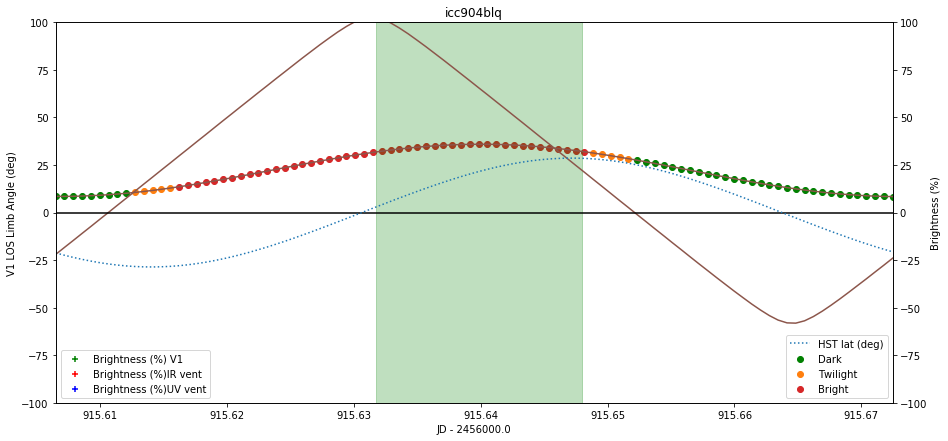

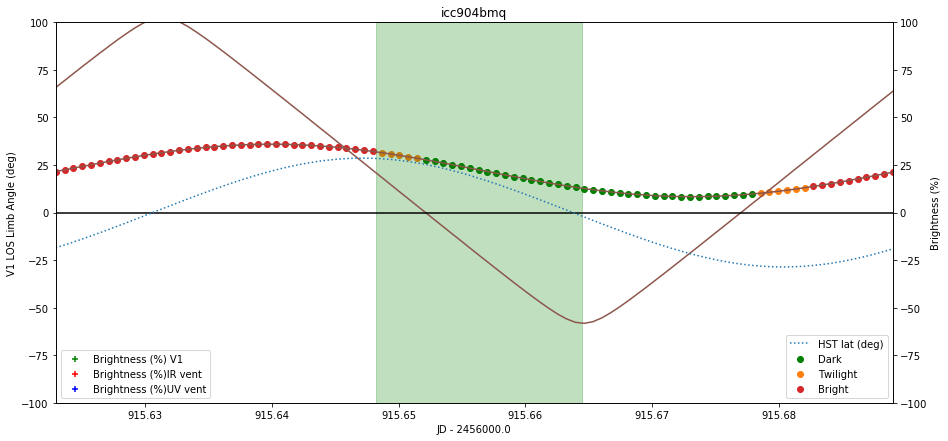

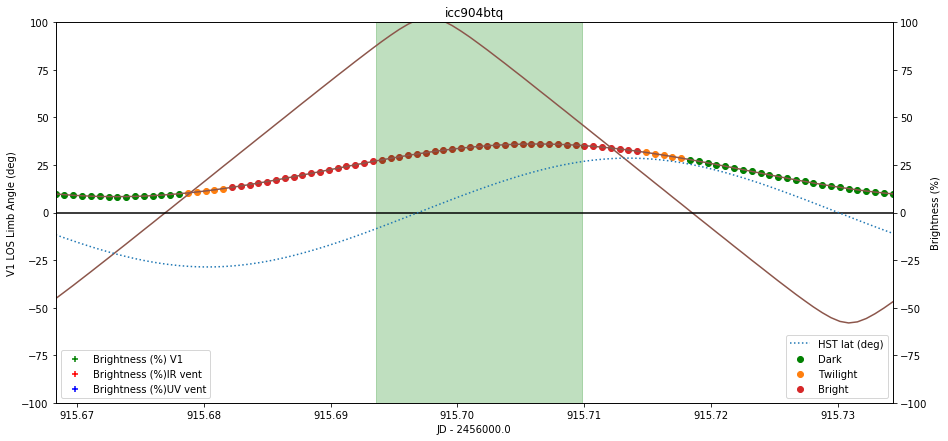

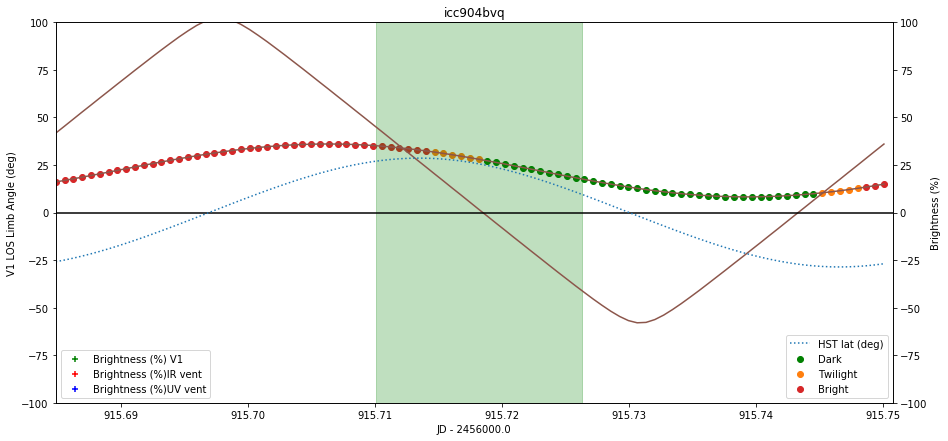

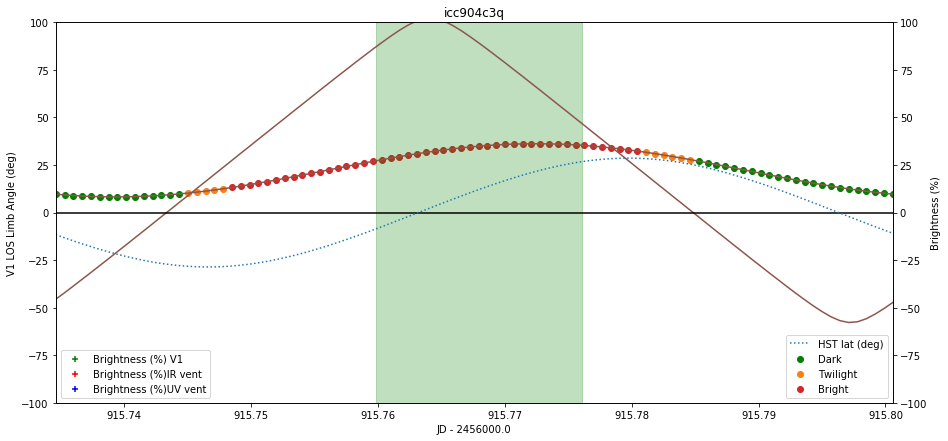

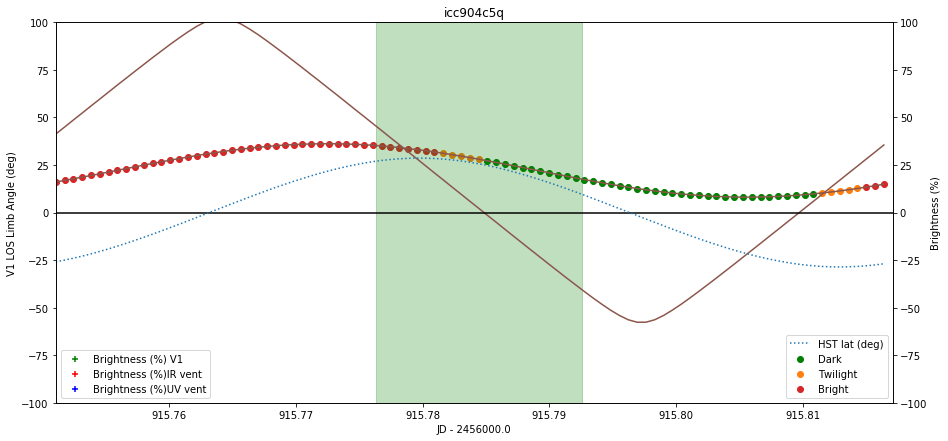

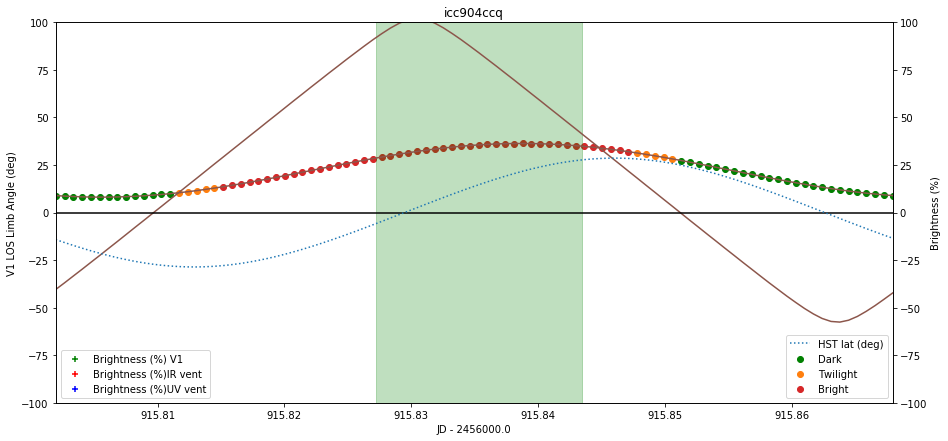

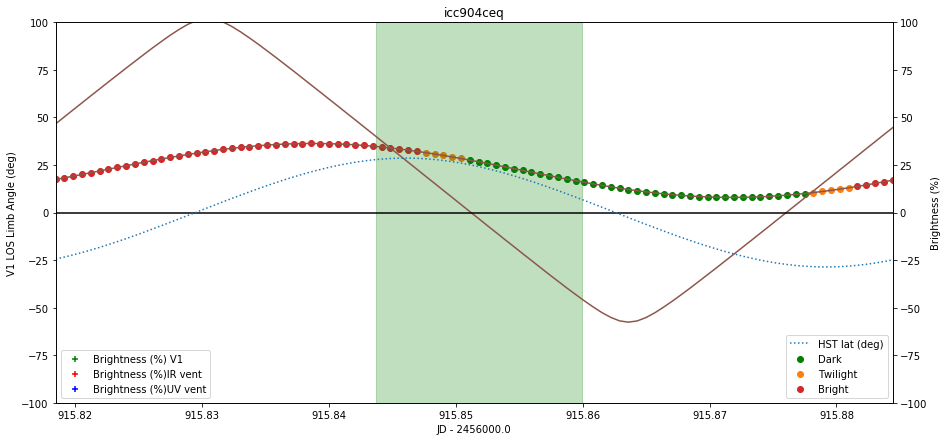

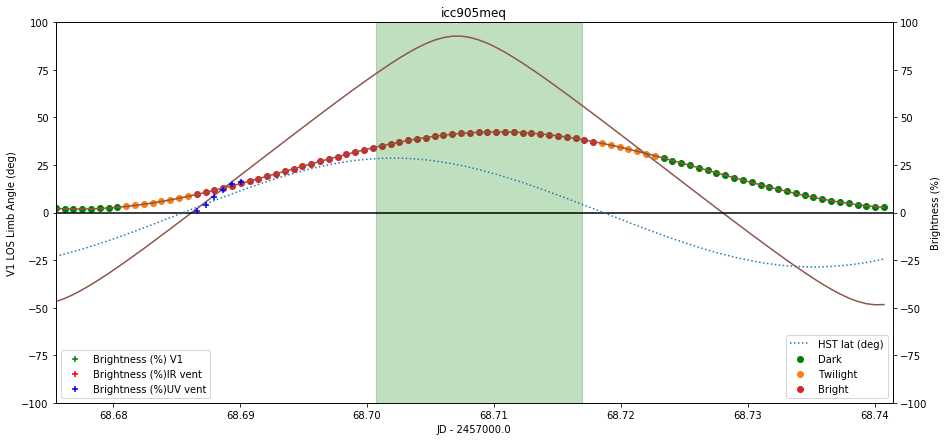

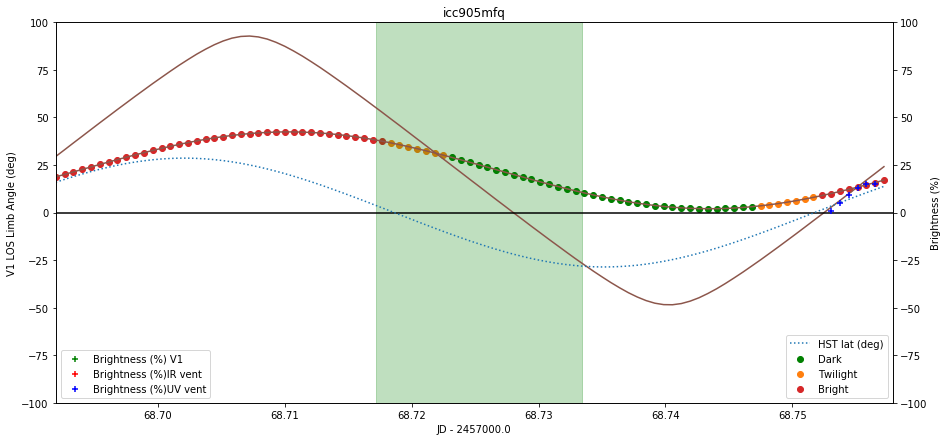

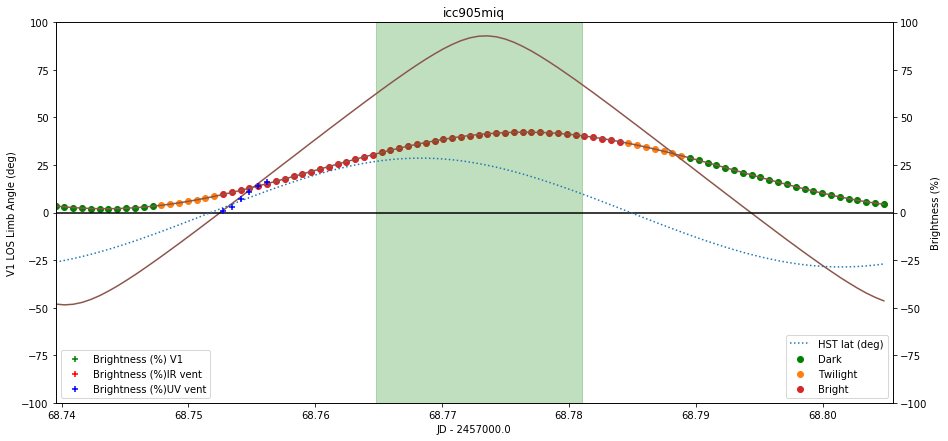

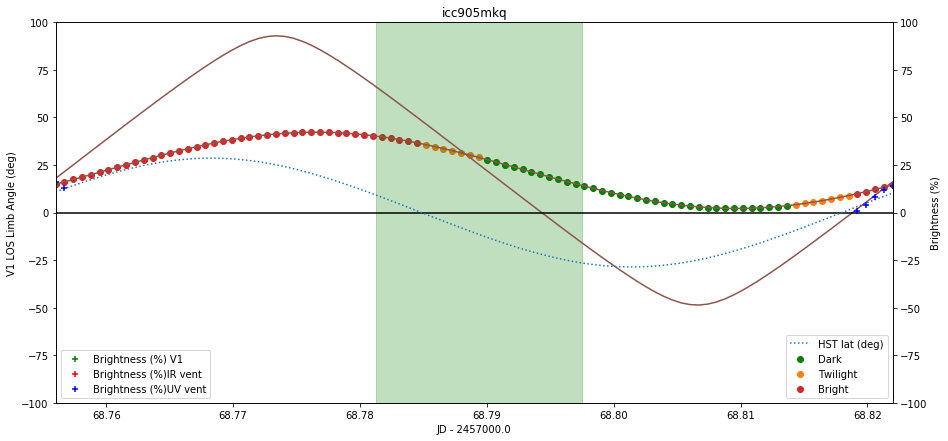

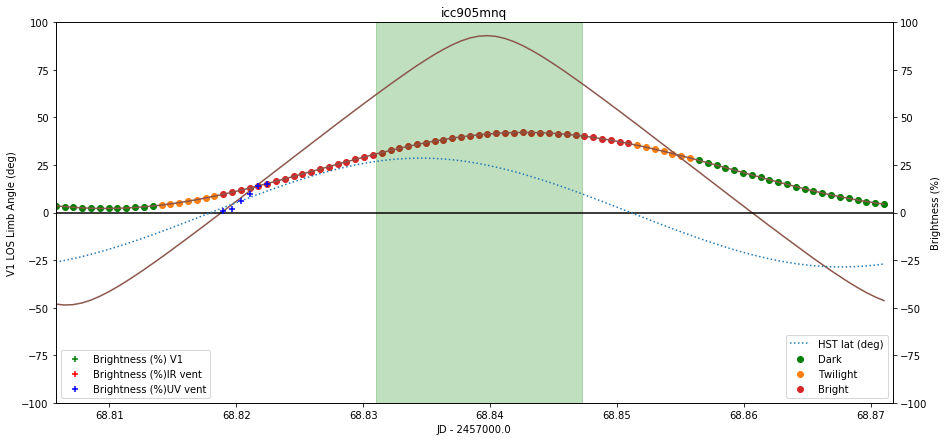

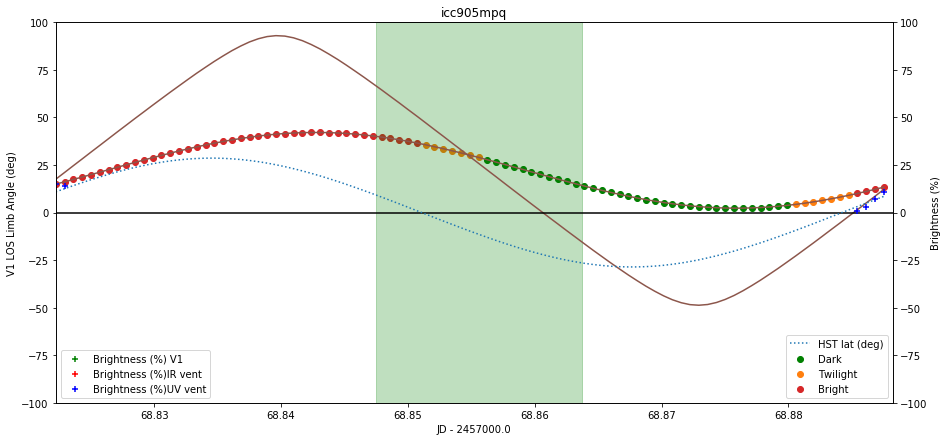

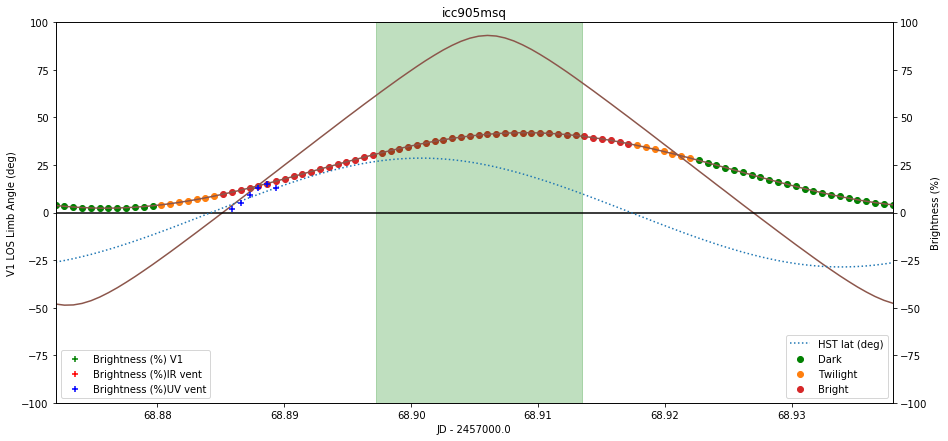

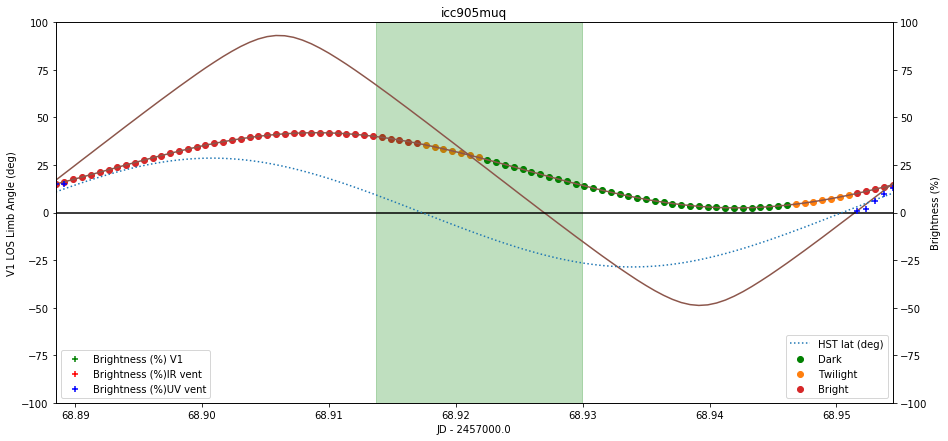

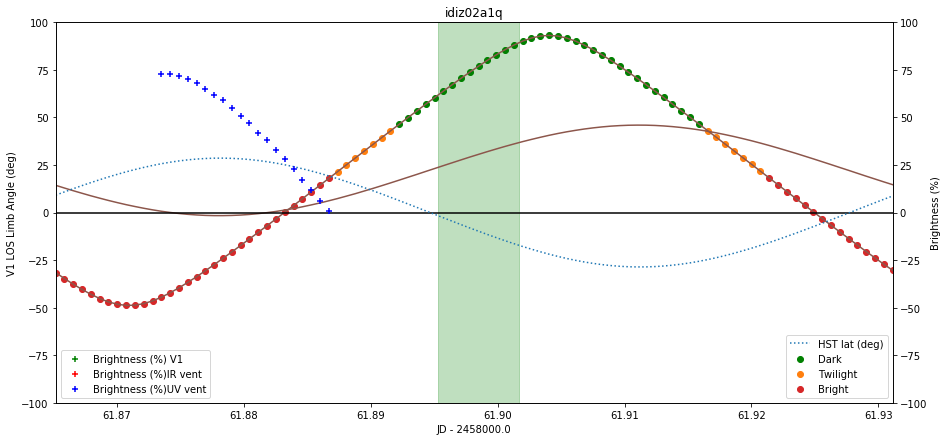

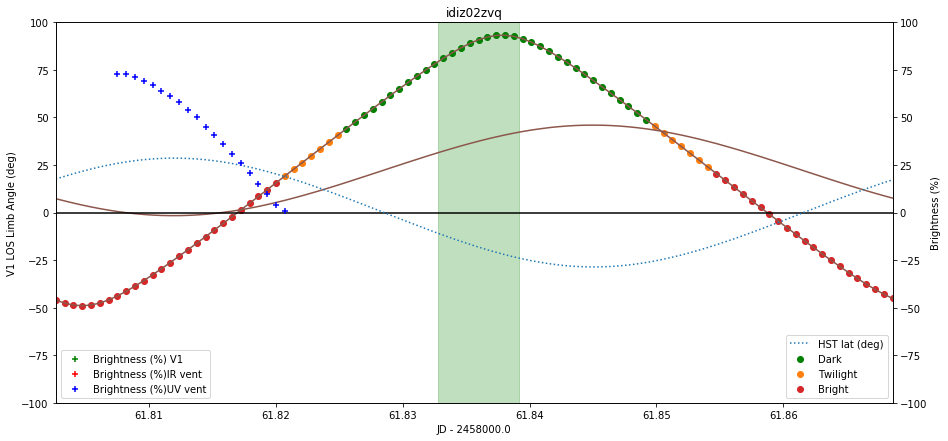

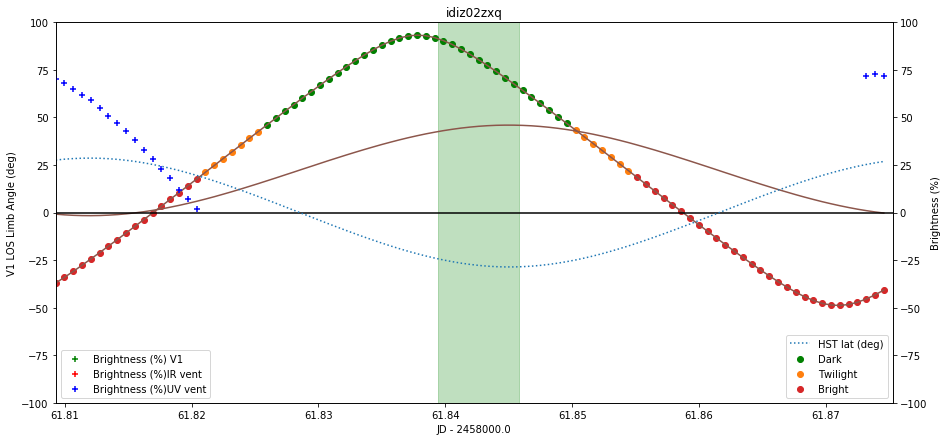

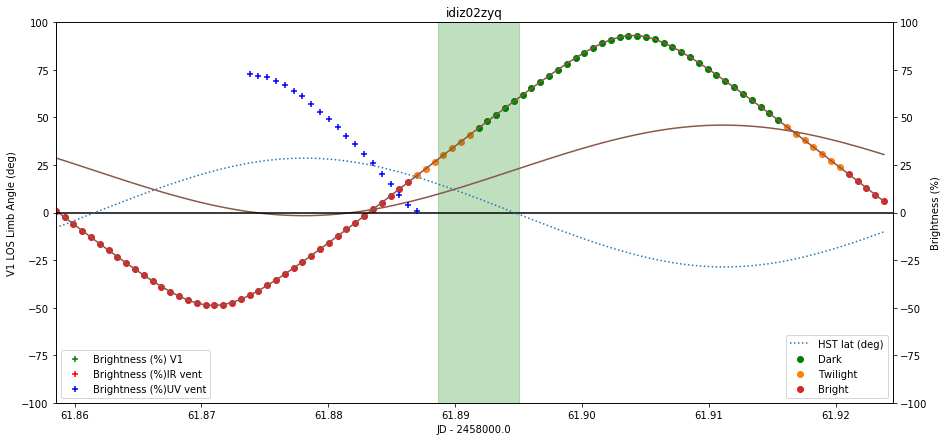

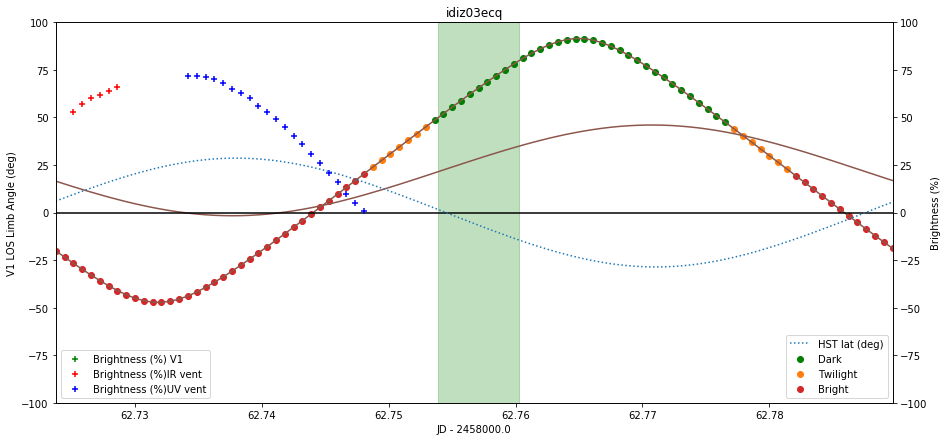

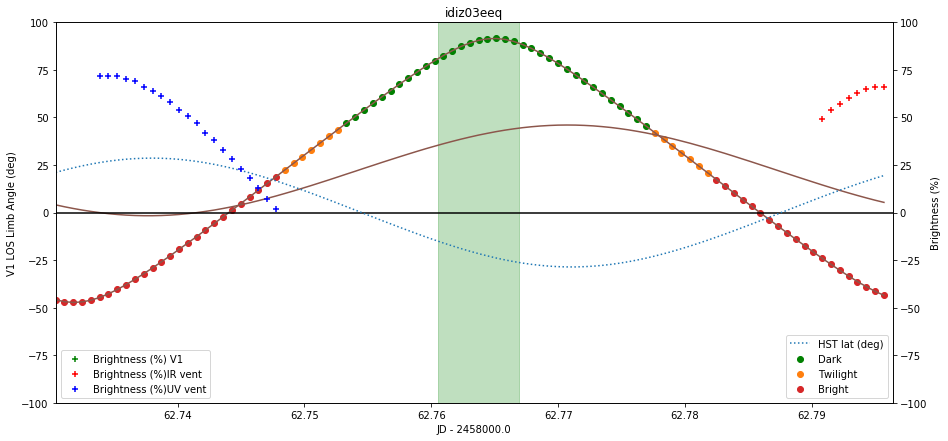

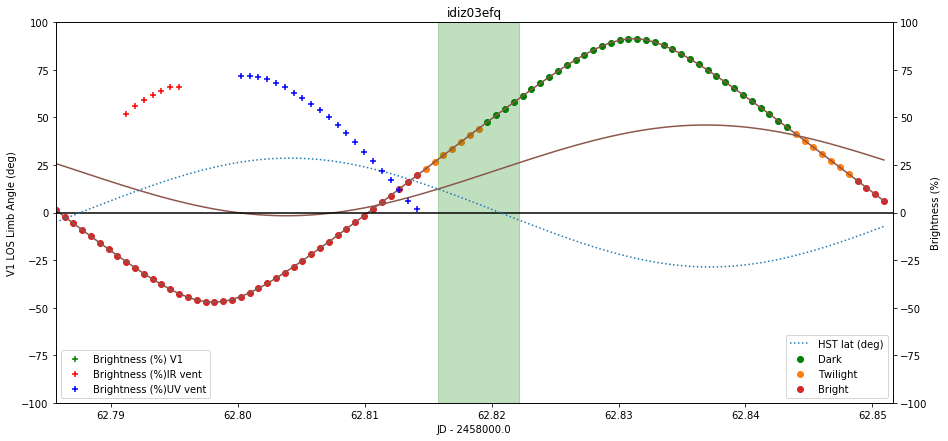

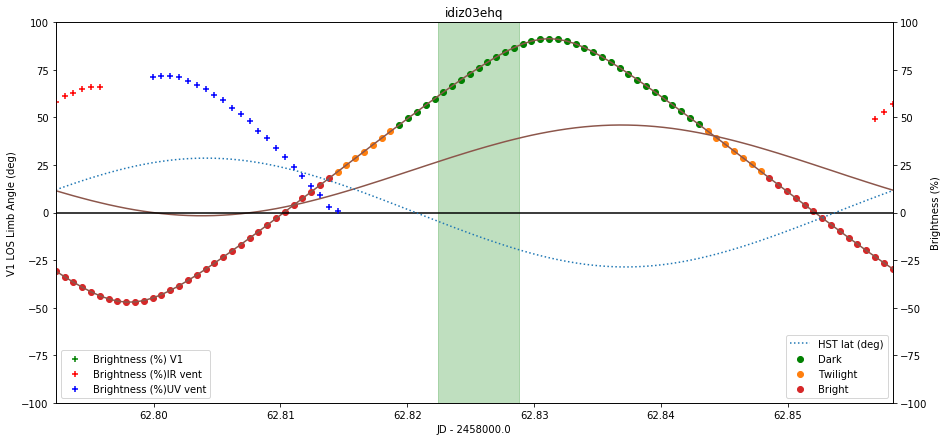

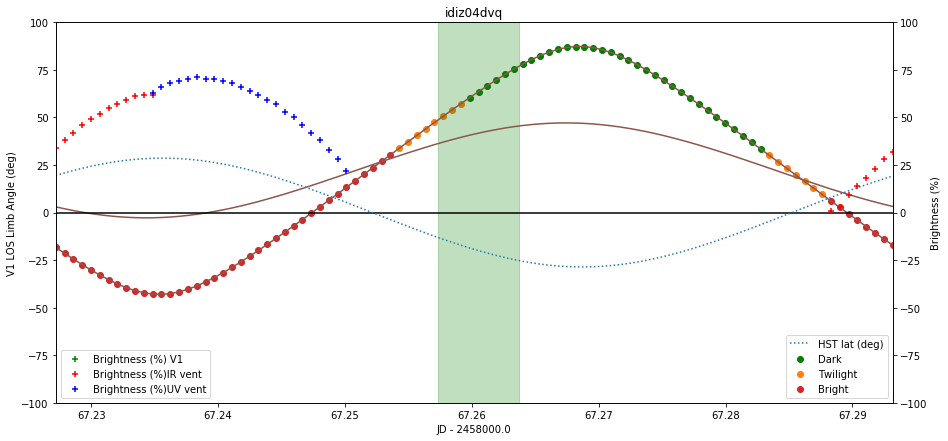

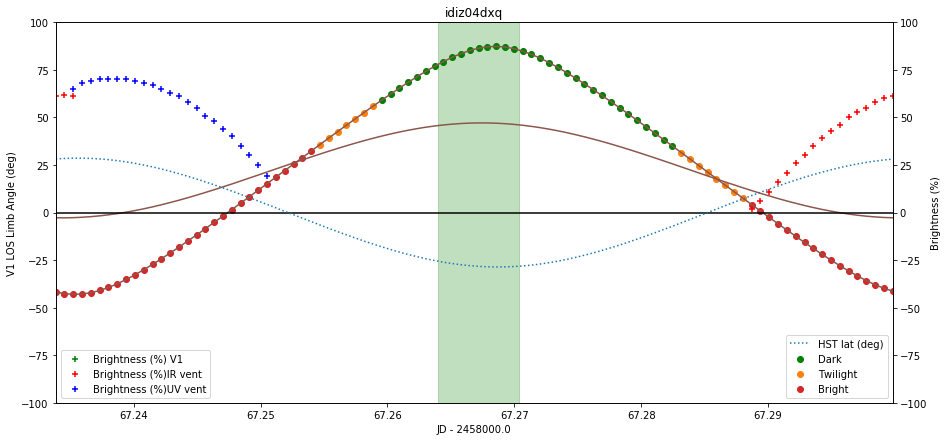

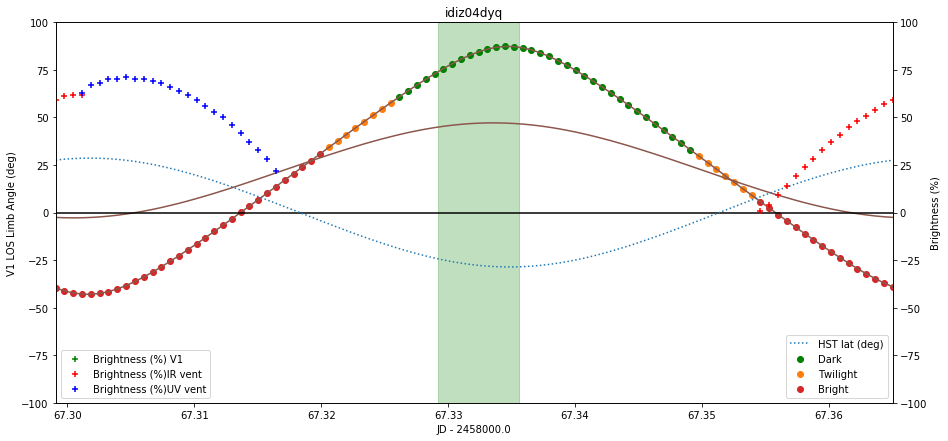

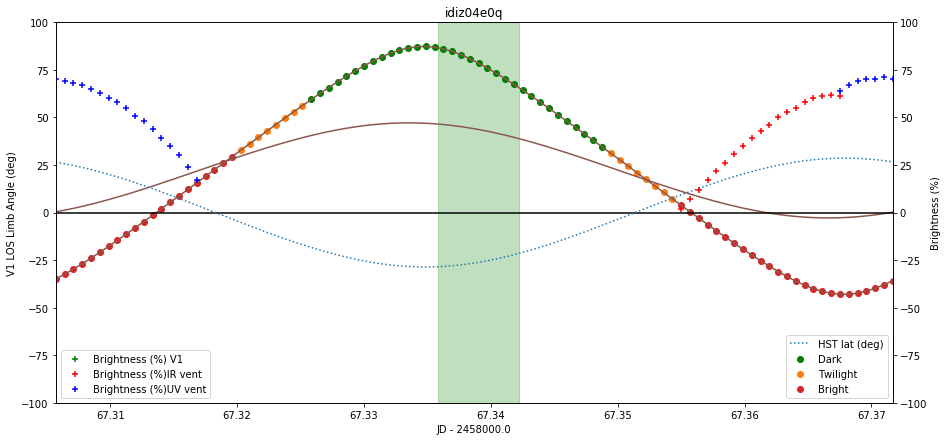

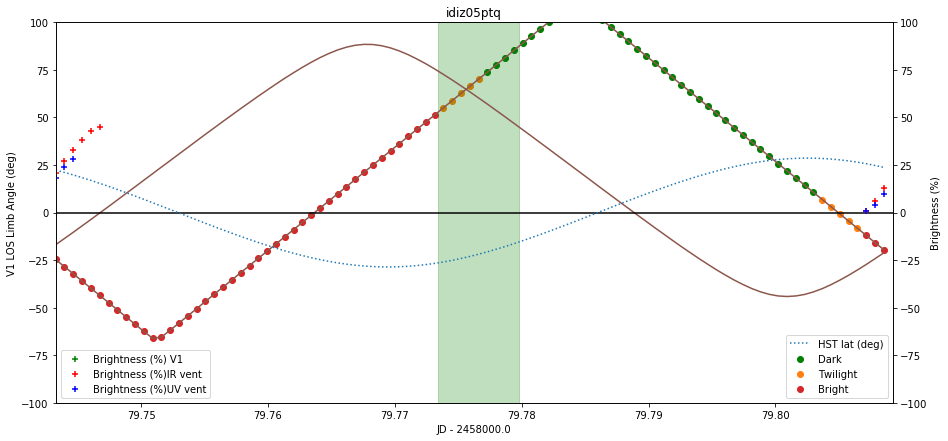

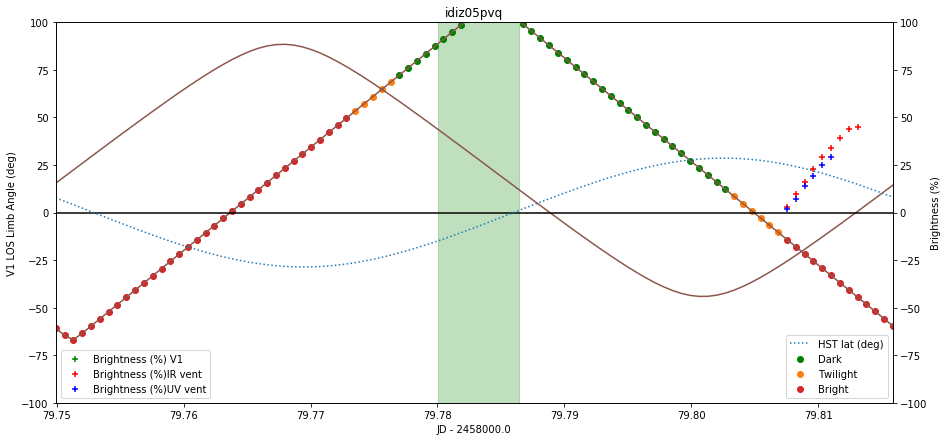

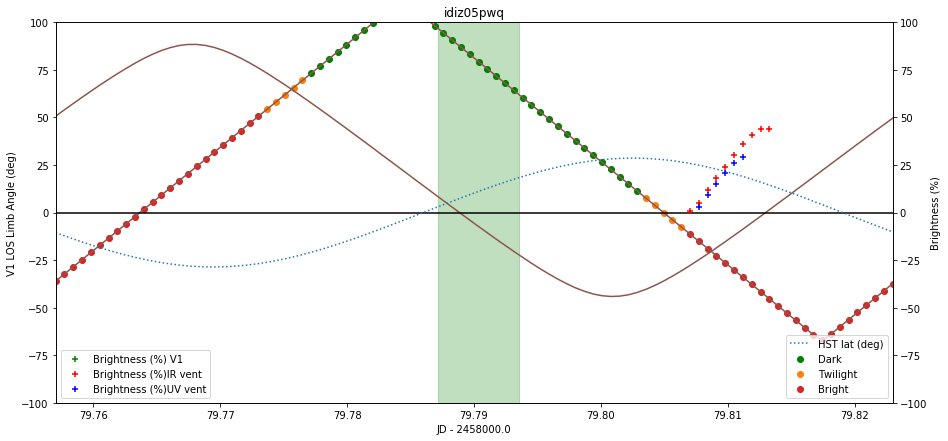

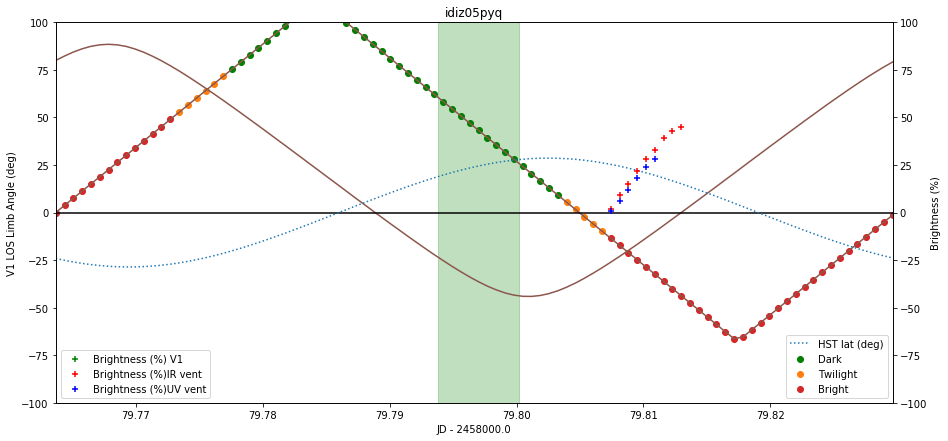

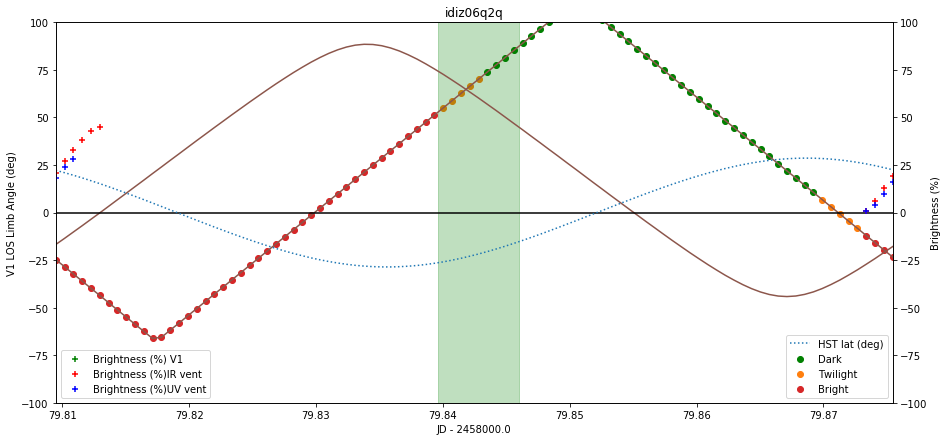

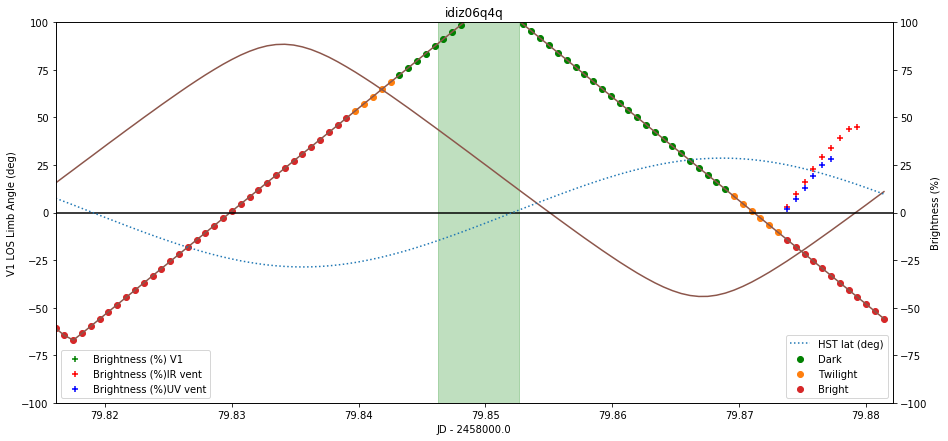

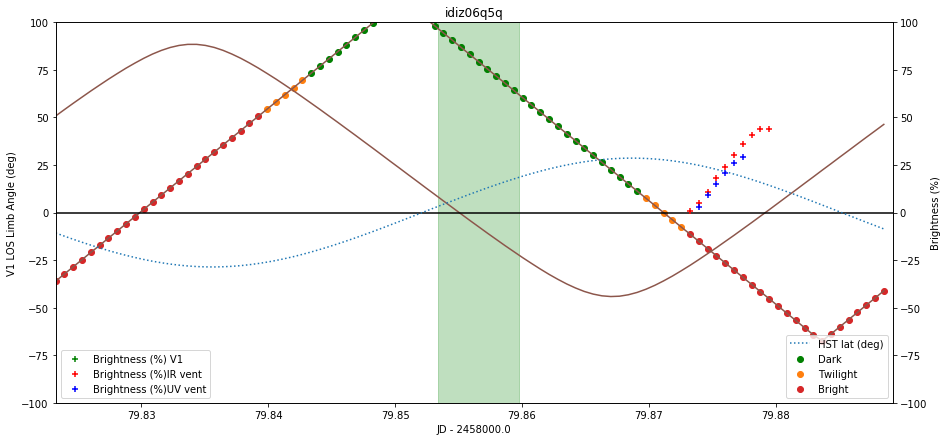

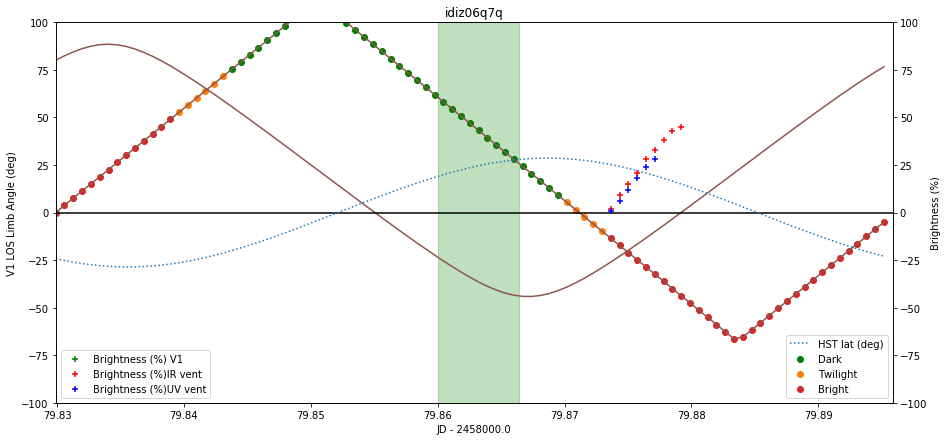

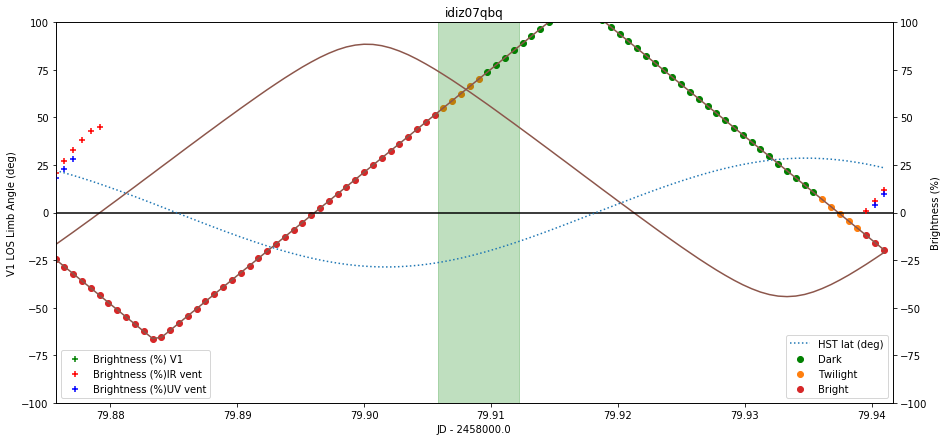

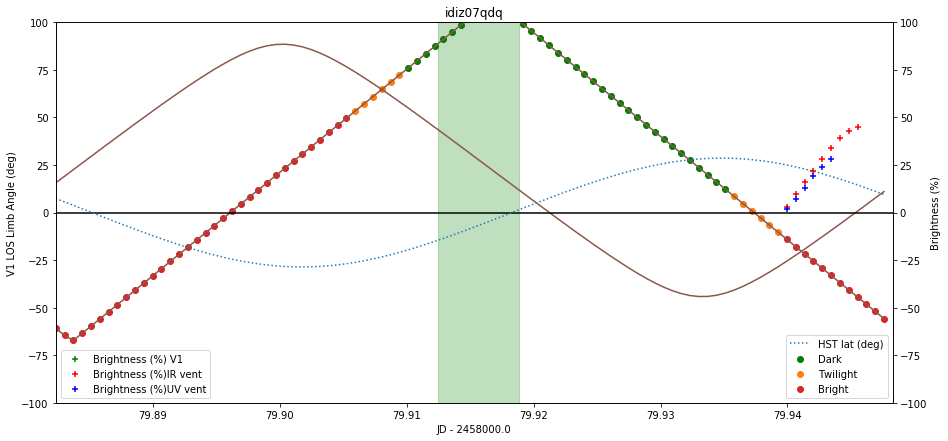

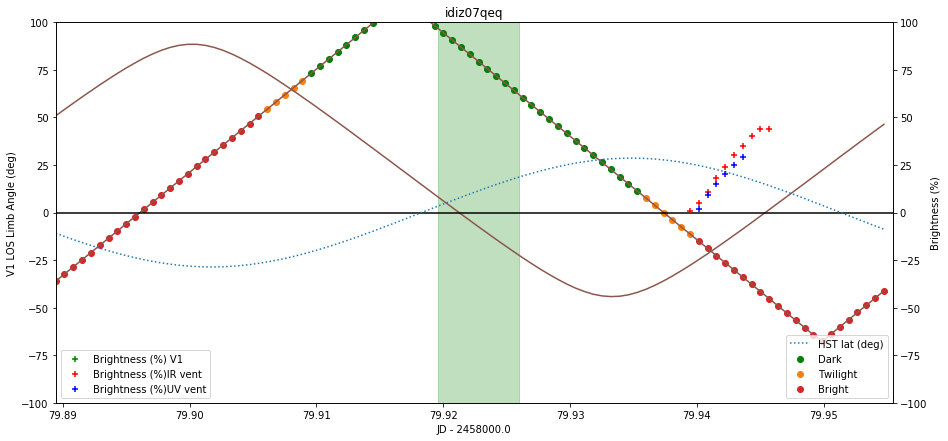

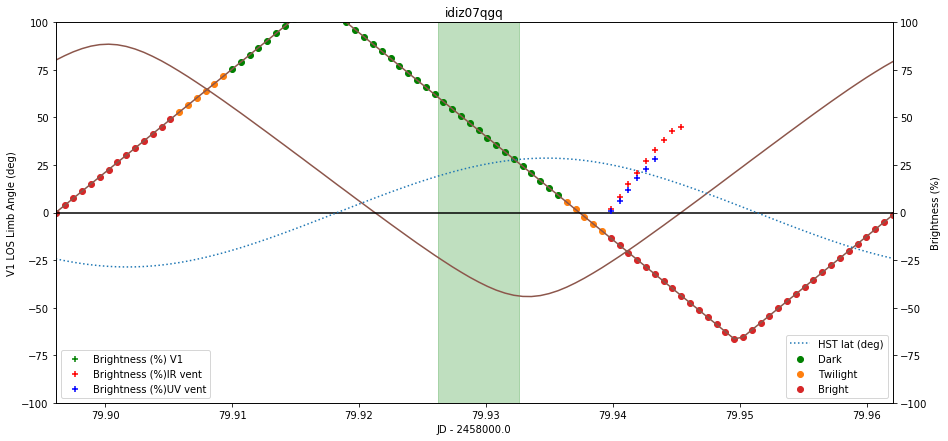

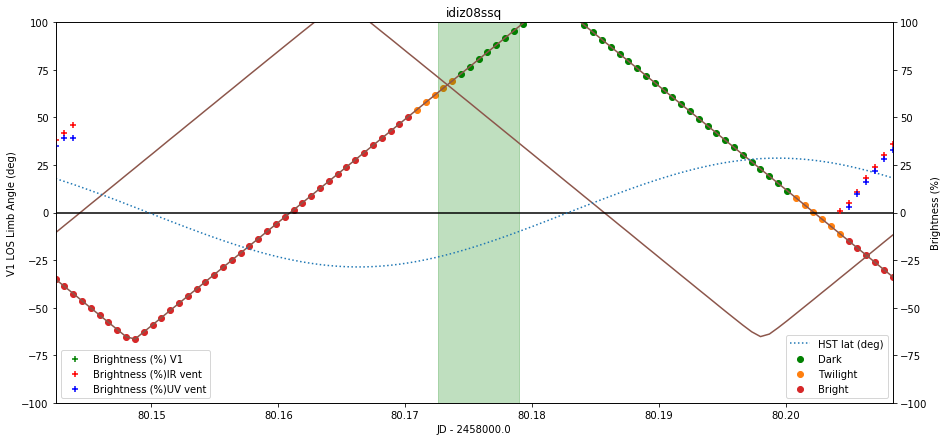

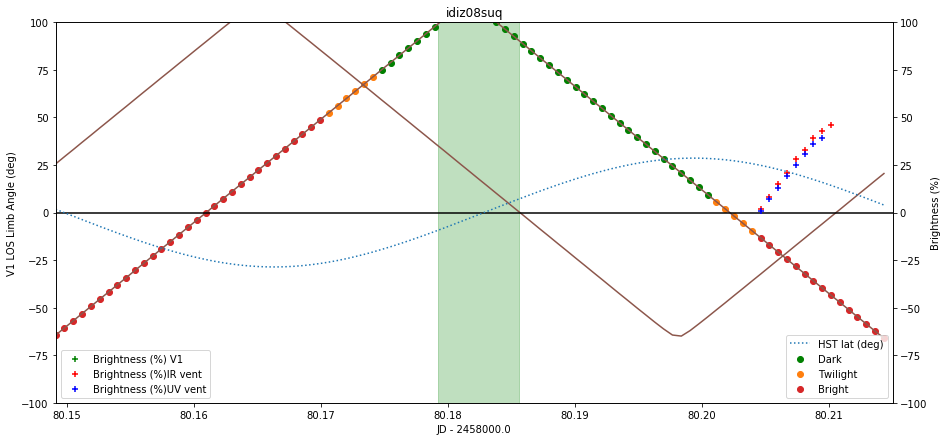

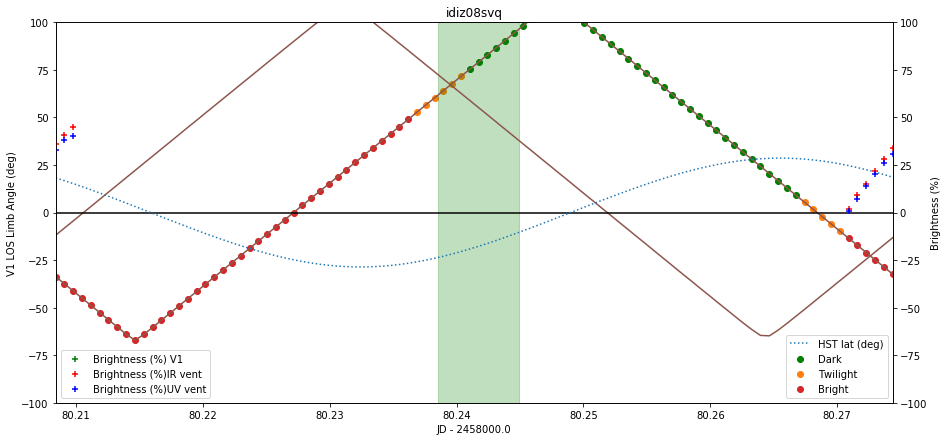

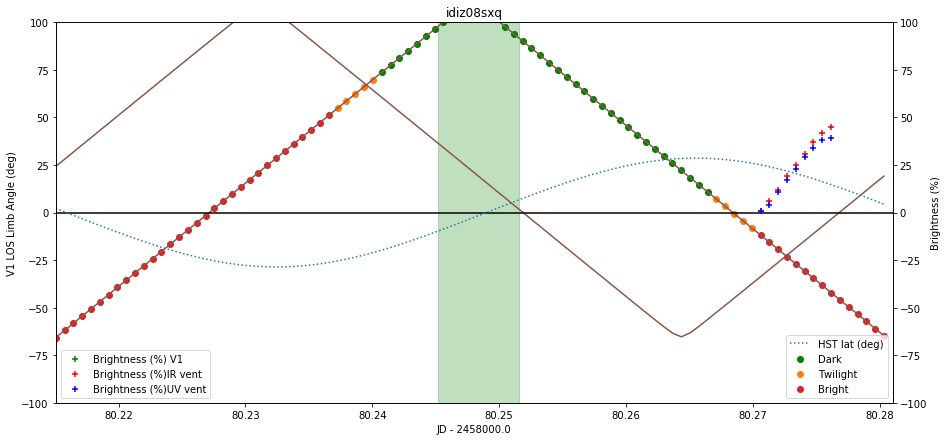

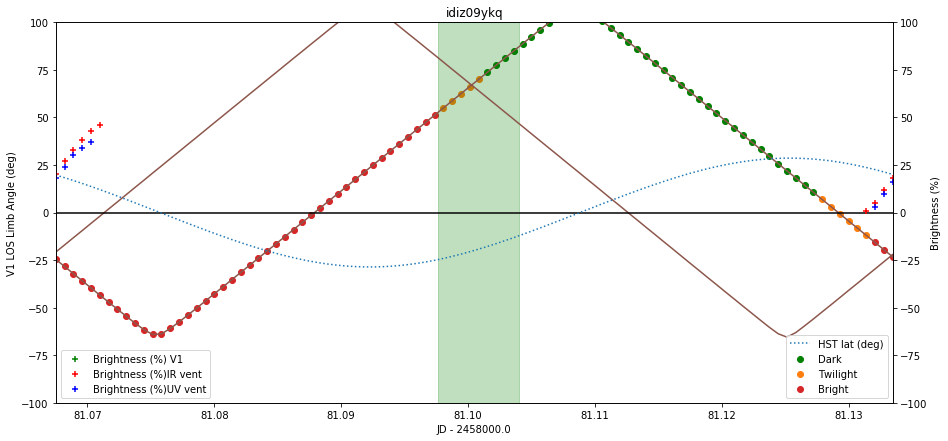

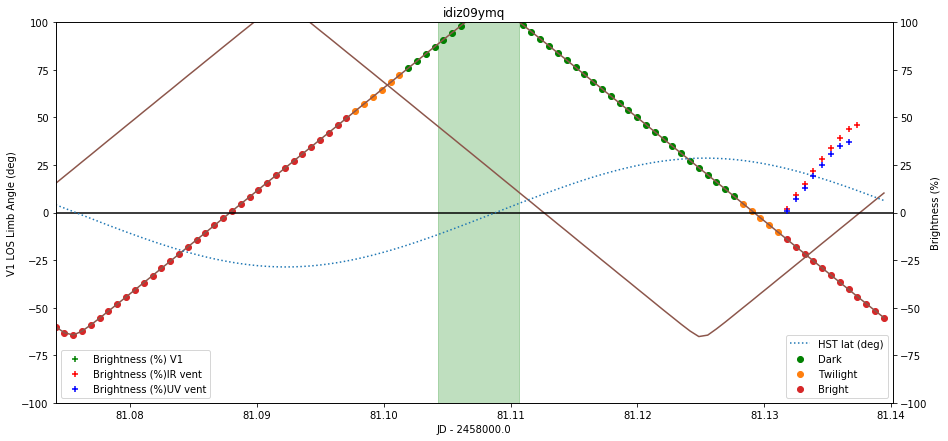

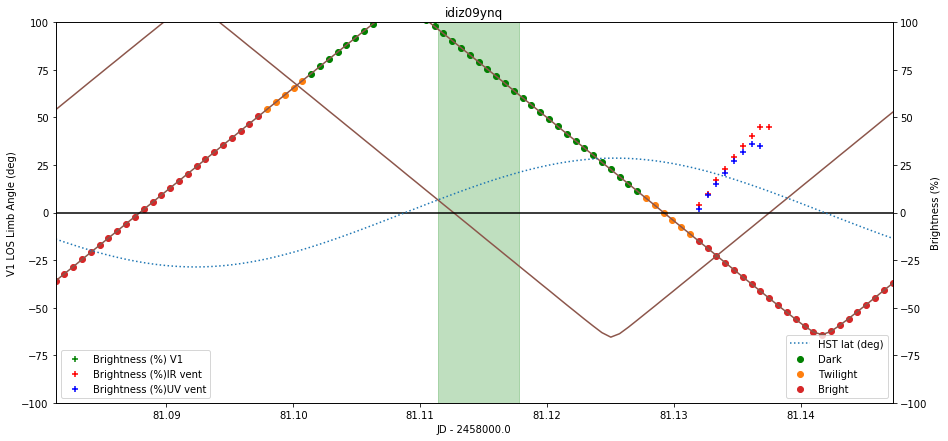

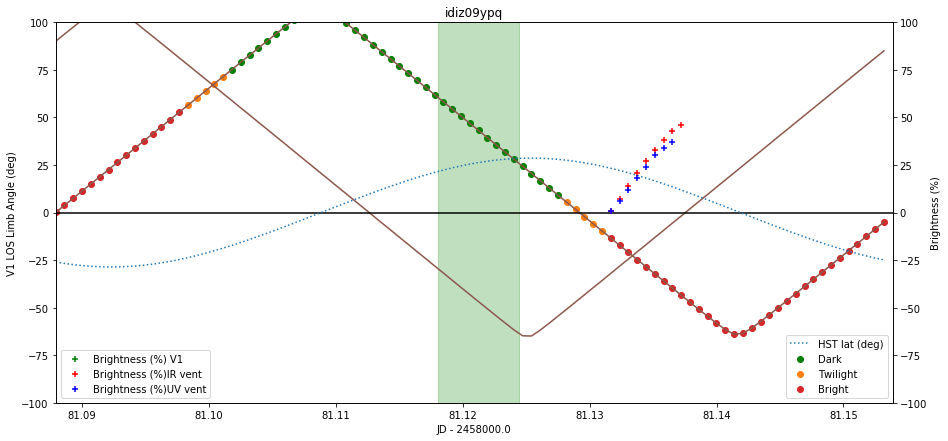

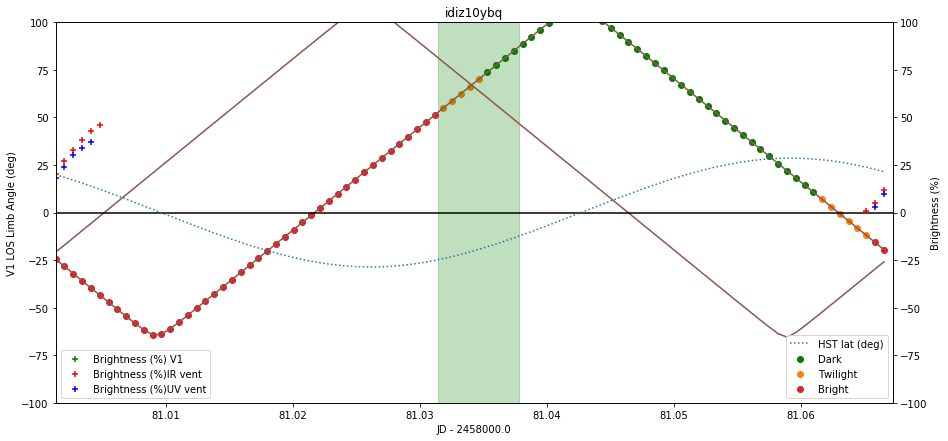

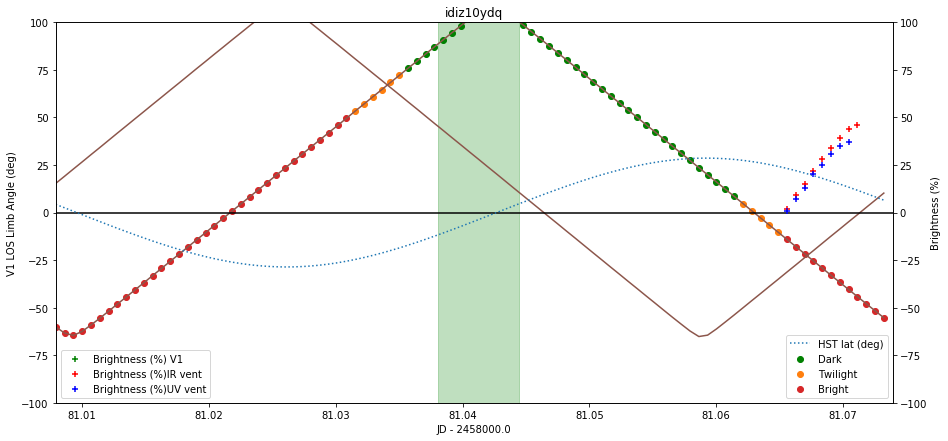

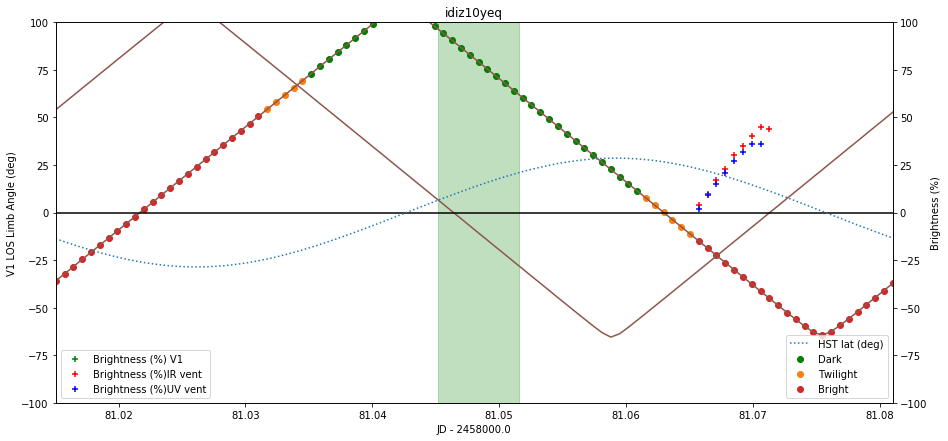

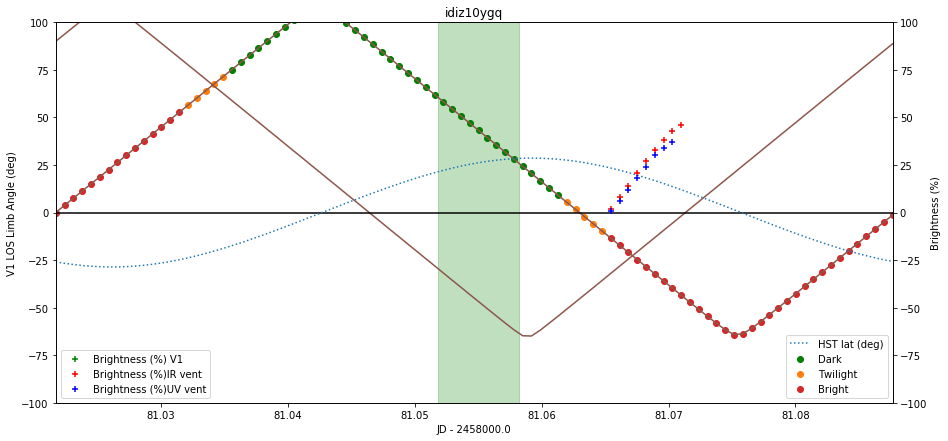

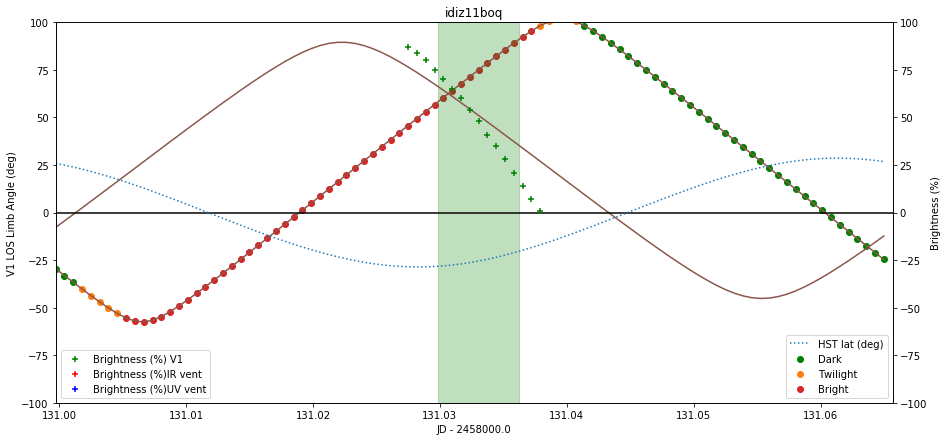

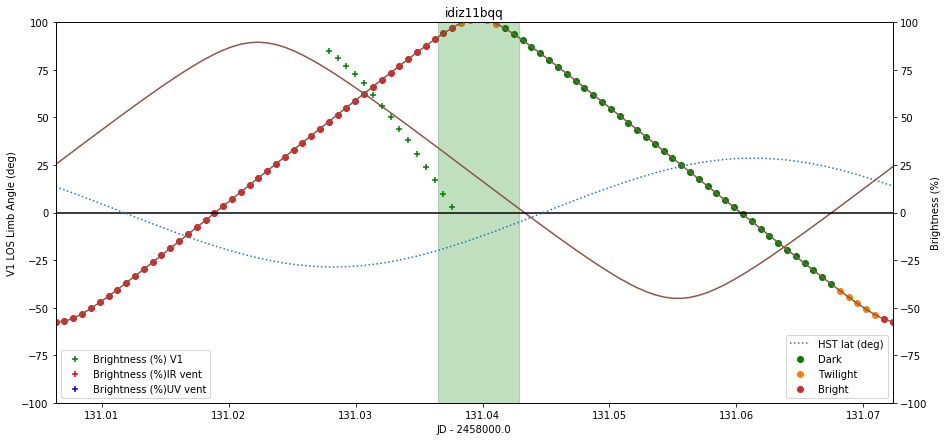

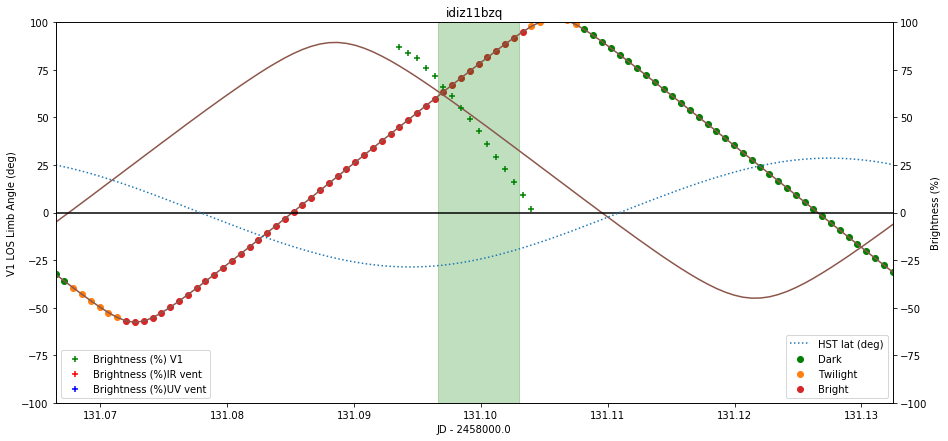

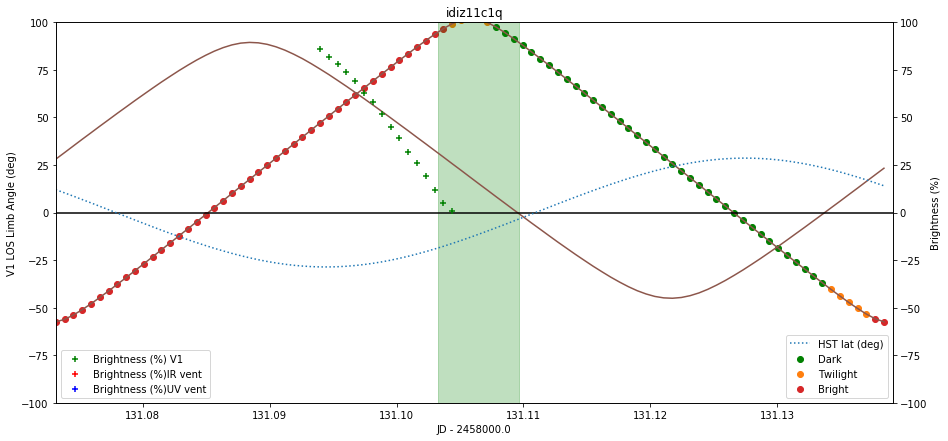

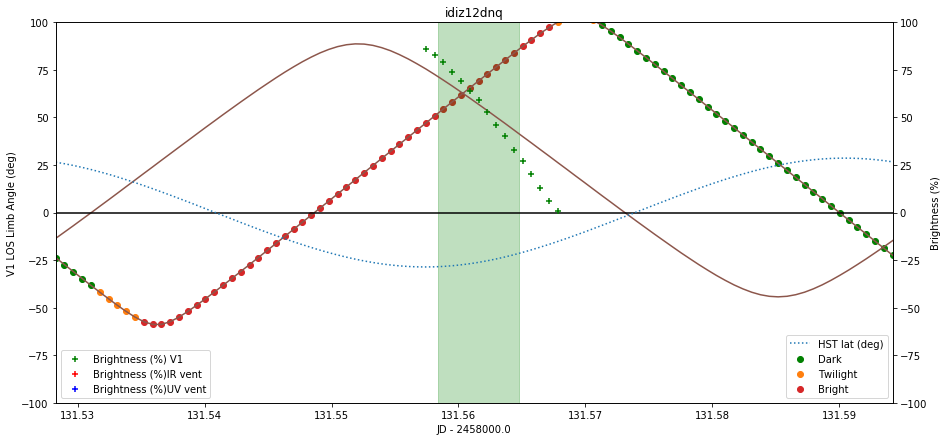

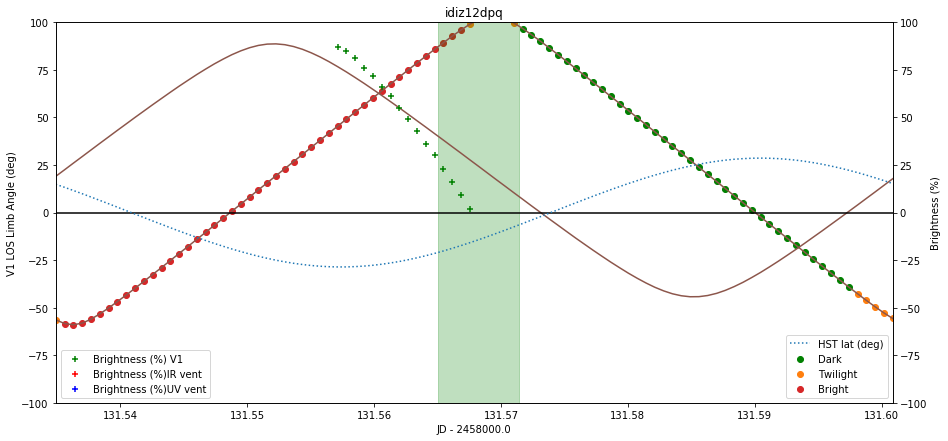

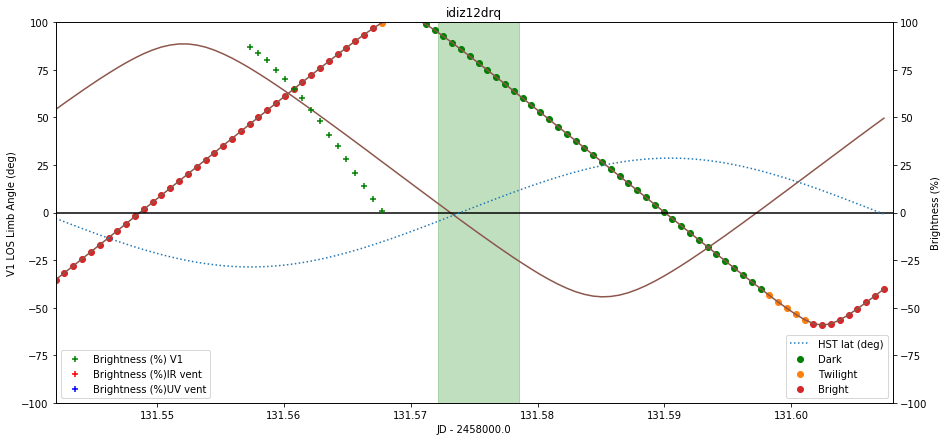

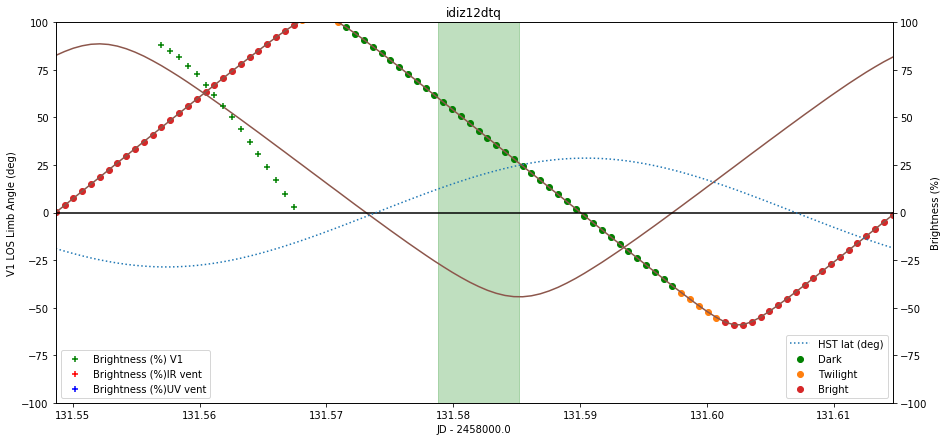

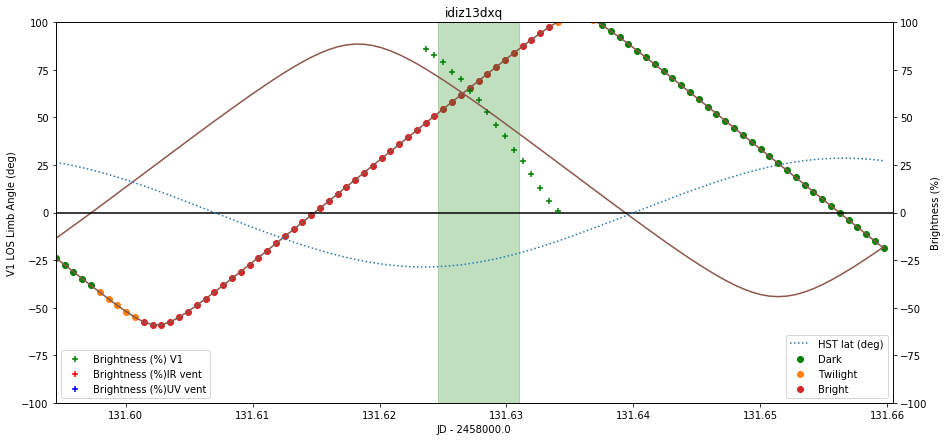

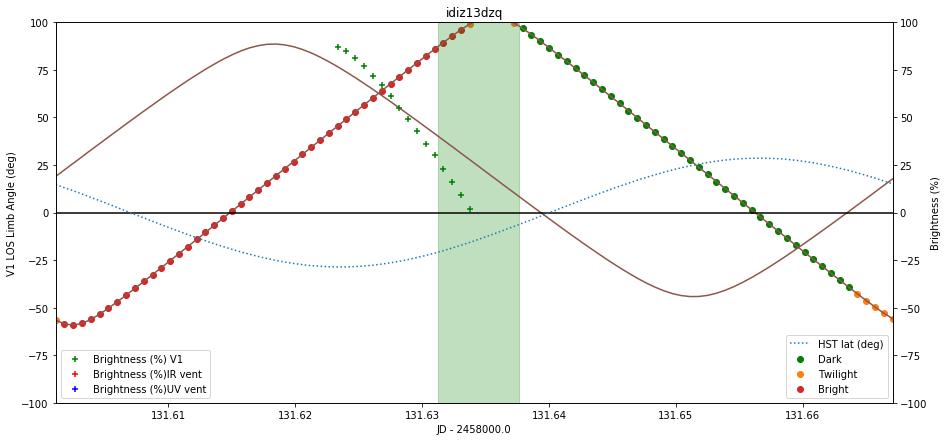

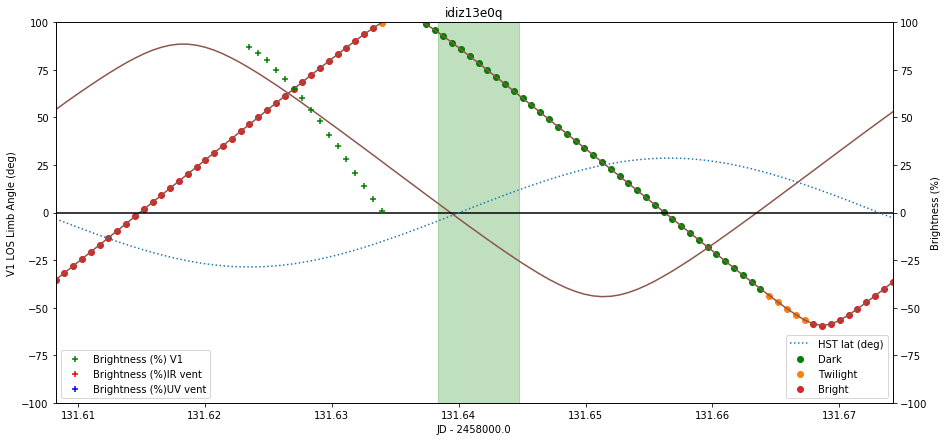

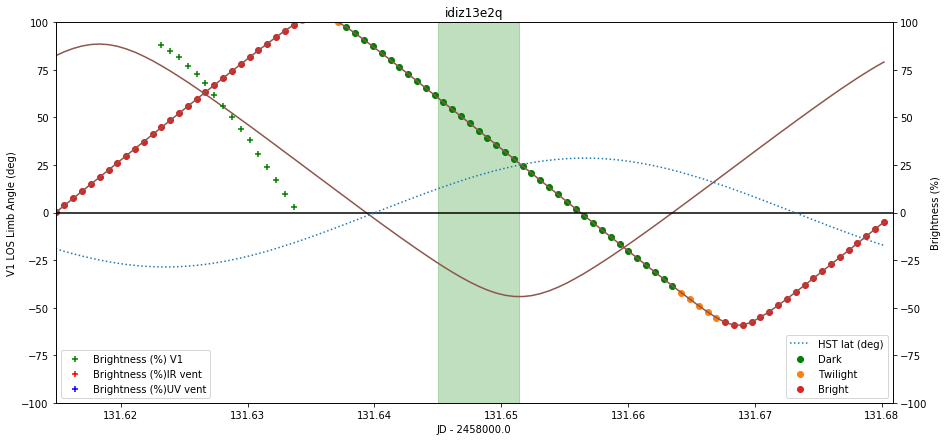

In [25]:
import glob, os, tqdm, shutil
missing = []
files = glob.glob("/Volumes/Data/GXXX_Back/G141_procV12_superclean/i*_flt.fits")
for ii,f in enumerate(files):
    print(ii+1,"of",len(files))
    obsid = os.path.split(f)[-1][0:9]
    if os.path.isfile("/Volumes/Data/GXXX_Back/G141_procV12_superclean/{}.earth.png".format(obsid)):
       # print(obsid,"done")
        continue
    jit = "/Volumes/Data/GXXX_Back/G141_procV12_superclean/{}??[01j]_jit.fits".format(obsid[0:6])
    if len(glob.glob(jit))==0:
        print(obsid,jit,"missing")
        missing.append(jit)
        continue
    get_data(obsid)
    jd=hst_geocentric(obsid)
    plot(obsid)
    raw = "{}_raw.fits".format(obsid)
    os.unlink(raw)
    shutil.move("{}.earth.png".format(obsid),"/Volumes/Data/GXXX_Back/G141_procV12_superclean/{}.earth.png".format(obsid))
    shutil.move("{}.earth".format(obsid),"/Volumes/Data/GXXX_Back/G141_procV12_superclean/{}.earth".format(obsid))
    clear_output(wait=True)
    

In [26]:
missing

[]

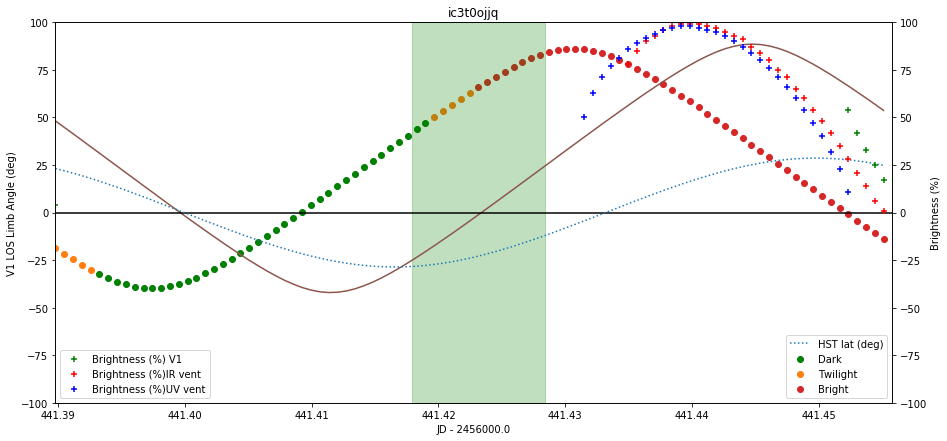

In [46]:
earth_radius = 0 #+ 670 # Adding athmosphere...

obsid = "ic3t0ojjq"
get_data(obsid)
jd=hst_geocentric(obsid)
plot(obsid)

In [40]:
import glob, os, tqdm
missing = []
files = glob.glob("/Volumes/Data/GXXX_Back/G141_proc/*_flt.fits")
for f in tqdm.tqdm(files):
    path = os.path.split(f)[0]
    obsid = os.path.split(f)[-1][0:9]
    if os.path.isfile("{}.earth.png".format(obsid)):
       # print(obsid,"done")
        continue
    jit = "/Volumes/Data/GXXX_Back/G141_proc/{}??[0j]_jit.fits".format(obsid[0:6])
    if len(glob.glob(jit))==0:
        print(obsid,jit,"missing")
        missing.append(jit)
        continue
    get_data(obsid)
    jd=hst_geocentric(obsid)
    plot(obsid)
    raw = "{}_raw.fits".format(obsid)
    os.unlink(raw)
    oname = "{}.earth".format(obsid)
    import shutil
    shutil.move(oname,os.path.join(path,oname))
    print(oname)

 74%|███████▍  | 2300/3091 [00:00<00:00, 11756.00it/s]

ickt16hmq /Volumes/Data/GXXX_Back/G141_proc/ickt16??[0j]_jit.fits missing
ickt16hqq /Volumes/Data/GXXX_Back/G141_proc/ickt16??[0j]_jit.fits missing
ickt16i1q /Volumes/Data/GXXX_Back/G141_proc/ickt16??[0j]_jit.fits missing
ickt16icq /Volumes/Data/GXXX_Back/G141_proc/ickt16??[0j]_jit.fits missing
ickt17ndq /Volumes/Data/GXXX_Back/G141_proc/ickt17??[0j]_jit.fits missing
ickt17ngq /Volumes/Data/GXXX_Back/G141_proc/ickt17??[0j]_jit.fits missing
ickt17njq /Volumes/Data/GXXX_Back/G141_proc/ickt17??[0j]_jit.fits missing
ickt17nmq /Volumes/Data/GXXX_Back/G141_proc/ickt17??[0j]_jit.fits missing
ickt18opq /Volumes/Data/GXXX_Back/G141_proc/ickt18??[0j]_jit.fits missing
ickt18pcq /Volumes/Data/GXXX_Back/G141_proc/ickt18??[0j]_jit.fits missing
ickt18pfq /Volumes/Data/GXXX_Back/G141_proc/ickt18??[0j]_jit.fits missing
ickt18piq /Volumes/Data/GXXX_Back/G141_proc/ickt18??[0j]_jit.fits missing
ickt19yfq /Volumes/Data/GXXX_Back/G141_proc/ickt19??[0j]_jit.fits missing
ickt19z6q /Volumes/Data/GXXX_Back/G141

id1k70dzq /Volumes/Data/GXXX_Back/G141_proc/id1k70??[0j]_jit.fits missing
id1k70e0q /Volumes/Data/GXXX_Back/G141_proc/id1k70??[0j]_jit.fits missing
id1k70e1q /Volumes/Data/GXXX_Back/G141_proc/id1k70??[0j]_jit.fits missing
id1k74omq /Volumes/Data/GXXX_Back/G141_proc/id1k74??[0j]_jit.fits missing
id1k76peq /Volumes/Data/GXXX_Back/G141_proc/id1k76??[0j]_jit.fits missing
id1k76pfq /Volumes/Data/GXXX_Back/G141_proc/id1k76??[0j]_jit.fits missing
id1k76pgq /Volumes/Data/GXXX_Back/G141_proc/id1k76??[0j]_jit.fits missing
id1k7ek9q /Volumes/Data/GXXX_Back/G141_proc/id1k7e??[0j]_jit.fits missing
id1k7ekbq /Volumes/Data/GXXX_Back/G141_proc/id1k7e??[0j]_jit.fits missing
id1k7fdpq /Volumes/Data/GXXX_Back/G141_proc/id1k7f??[0j]_jit.fits missing
id1k7fdrq /Volumes/Data/GXXX_Back/G141_proc/id1k7f??[0j]_jit.fits missing
id1k7jkoq /Volumes/Data/GXXX_Back/G141_proc/id1k7j??[0j]_jit.fits missing
id1k7jkqq /Volumes/Data/GXXX_Back/G141_proc/id1k7j??[0j]_jit.fits missing
id1k7opmq /Volumes/Data/GXXX_Back/G141

id1ke2xwq /Volumes/Data/GXXX_Back/G141_proc/id1ke2??[0j]_jit.fits missing
id1ke2xxq /Volumes/Data/GXXX_Back/G141_proc/id1ke2??[0j]_jit.fits missing
id1ke2xyq /Volumes/Data/GXXX_Back/G141_proc/id1ke2??[0j]_jit.fits missing
id1ke6irq /Volumes/Data/GXXX_Back/G141_proc/id1ke6??[0j]_jit.fits missing
id1ke6isq /Volumes/Data/GXXX_Back/G141_proc/id1ke6??[0j]_jit.fits missing
id1ke6itq /Volumes/Data/GXXX_Back/G141_proc/id1ke6??[0j]_jit.fits missing
id1keag8q /Volumes/Data/GXXX_Back/G141_proc/id1kea??[0j]_jit.fits missing
id1keag9q /Volumes/Data/GXXX_Back/G141_proc/id1kea??[0j]_jit.fits missing
id1keagaq /Volumes/Data/GXXX_Back/G141_proc/id1kea??[0j]_jit.fits missing
id1kebu6q /Volumes/Data/GXXX_Back/G141_proc/id1keb??[0j]_jit.fits missing
id1kebubq /Volumes/Data/GXXX_Back/G141_proc/id1keb??[0j]_jit.fits missing
id1keevbq /Volumes/Data/GXXX_Back/G141_proc/id1kee??[0j]_jit.fits missing
id1keevdq /Volumes/Data/GXXX_Back/G141_proc/id1kee??[0j]_jit.fits missing
id1keevfq /Volumes/Data/GXXX_Back/G141

id1khibcq /Volumes/Data/GXXX_Back/G141_proc/id1khi??[0j]_jit.fits missing
id1khlbeq /Volumes/Data/GXXX_Back/G141_proc/id1khl??[0j]_jit.fits missing
id1khlbfq /Volumes/Data/GXXX_Back/G141_proc/id1khl??[0j]_jit.fits missing
id1khoodq /Volumes/Data/GXXX_Back/G141_proc/id1kho??[0j]_jit.fits missing
id1khoofq /Volumes/Data/GXXX_Back/G141_proc/id1kho??[0j]_jit.fits missing
id1khtzsq /Volumes/Data/GXXX_Back/G141_proc/id1kht??[0j]_jit.fits missing
id1khtztq /Volumes/Data/GXXX_Back/G141_proc/id1kht??[0j]_jit.fits missing
id1khuahq /Volumes/Data/GXXX_Back/G141_proc/id1khu??[0j]_jit.fits missing
id1khuaiq /Volumes/Data/GXXX_Back/G141_proc/id1khu??[0j]_jit.fits missing
id1khvhjq /Volumes/Data/GXXX_Back/G141_proc/id1khv??[0j]_jit.fits missing
id1khvhlq /Volumes/Data/GXXX_Back/G141_proc/id1khv??[0j]_jit.fits missing
id1khvhnq /Volumes/Data/GXXX_Back/G141_proc/id1khv??[0j]_jit.fits missing
id1khwi0q /Volumes/Data/GXXX_Back/G141_proc/id1khw??[0j]_jit.fits missing
id1khwi1q /Volumes/Data/GXXX_Back/G141

id7h22uiq /Volumes/Data/GXXX_Back/G141_proc/id7h22??[0j]_jit.fits missing
id7h22unq /Volumes/Data/GXXX_Back/G141_proc/id7h22??[0j]_jit.fits missing
id7h22upq /Volumes/Data/GXXX_Back/G141_proc/id7h22??[0j]_jit.fits missing
id7h23q3q /Volumes/Data/GXXX_Back/G141_proc/id7h23??[0j]_jit.fits missing
id7h23q4q /Volumes/Data/GXXX_Back/G141_proc/id7h23??[0j]_jit.fits missing
id7h23q9q /Volumes/Data/GXXX_Back/G141_proc/id7h23??[0j]_jit.fits missing
id7h23qbq /Volumes/Data/GXXX_Back/G141_proc/id7h23??[0j]_jit.fits missing
id7h24fzq /Volumes/Data/GXXX_Back/G141_proc/id7h24??[0j]_jit.fits missing
id7h24g0q /Volumes/Data/GXXX_Back/G141_proc/id7h24??[0j]_jit.fits missing
id7h24g8q /Volumes/Data/GXXX_Back/G141_proc/id7h24??[0j]_jit.fits missing
id7h24h2q /Volumes/Data/GXXX_Back/G141_proc/id7h24??[0j]_jit.fits missing
id7h25vrq /Volumes/Data/GXXX_Back/G141_proc/id7h25??[0j]_jit.fits missing
id7h25vsq /Volumes/Data/GXXX_Back/G141_proc/id7h25??[0j]_jit.fits missing
id7h25vxq /Volumes/Data/GXXX_Back/G141

 92%|█████████▏| 2851/3091 [00:08<00:01, 215.04it/s]  

id7h39ksq /Volumes/Data/GXXX_Back/G141_proc/id7h39??[0j]_jit.fits missing
id7h40d5q /Volumes/Data/GXXX_Back/G141_proc/id7h40??[0j]_jit.fits missing
id7h40d6q /Volumes/Data/GXXX_Back/G141_proc/id7h40??[0j]_jit.fits missing
id7h40dbq /Volumes/Data/GXXX_Back/G141_proc/id7h40??[0j]_jit.fits missing
id7h40ddq /Volumes/Data/GXXX_Back/G141_proc/id7h40??[0j]_jit.fits missing
id7h41v0q /Volumes/Data/GXXX_Back/G141_proc/id7h41??[0j]_jit.fits missing
id7h41v5q /Volumes/Data/GXXX_Back/G141_proc/id7h41??[0j]_jit.fits missing
id7h41vbq /Volumes/Data/GXXX_Back/G141_proc/id7h41??[0j]_jit.fits missing
id7h41vwq /Volumes/Data/GXXX_Back/G141_proc/id7h41??[0j]_jit.fits missing
id7h42hoq /Volumes/Data/GXXX_Back/G141_proc/id7h42??[0j]_jit.fits missing
id7h42hpq /Volumes/Data/GXXX_Back/G141_proc/id7h42??[0j]_jit.fits missing
id7h42huq /Volumes/Data/GXXX_Back/G141_proc/id7h42??[0j]_jit.fits missing
id7h42hwq /Volumes/Data/GXXX_Back/G141_proc/id7h42??[0j]_jit.fits missing
id7h43xtq /Volumes/Data/GXXX_Back/G141

idncc1qqq /Volumes/Data/GXXX_Back/G141_proc/idncc1??[0j]_jit.fits missing
idncc1qyq /Volumes/Data/GXXX_Back/G141_proc/idncc1??[0j]_jit.fits missing
idncc2lkq /Volumes/Data/GXXX_Back/G141_proc/idncc2??[0j]_jit.fits missing
idncc2lmq /Volumes/Data/GXXX_Back/G141_proc/idncc2??[0j]_jit.fits missing
idncc3ctq /Volumes/Data/GXXX_Back/G141_proc/idncc3??[0j]_jit.fits missing
idncc3dkq /Volumes/Data/GXXX_Back/G141_proc/idncc3??[0j]_jit.fits missing
idncc3dmq /Volumes/Data/GXXX_Back/G141_proc/idncc3??[0j]_jit.fits missing
idncc4vvq /Volumes/Data/GXXX_Back/G141_proc/idncc4??[0j]_jit.fits missing
idncc4w2q /Volumes/Data/GXXX_Back/G141_proc/idncc4??[0j]_jit.fits missing
idncc4w4q /Volumes/Data/GXXX_Back/G141_proc/idncc4??[0j]_jit.fits missing
idncd1tlq /Volumes/Data/GXXX_Back/G141_proc/idncd1??[0j]_jit.fits missing
idncd1tqq /Volumes/Data/GXXX_Back/G141_proc/idncd1??[0j]_jit.fits missing
idncd1tsq /Volumes/Data/GXXX_Back/G141_proc/idncd1??[0j]_jit.fits missing
idncd2etq /Volumes/Data/GXXX_Back/G141

idnco1uvq /Volumes/Data/GXXX_Back/G141_proc/idnco1??[0j]_jit.fits missing
idnco1v4q /Volumes/Data/GXXX_Back/G141_proc/idnco1??[0j]_jit.fits missing
idnco1v9q /Volumes/Data/GXXX_Back/G141_proc/idnco1??[0j]_jit.fits missing
idnco1w4q /Volumes/Data/GXXX_Back/G141_proc/idnco1??[0j]_jit.fits missing
idnco2nuq /Volumes/Data/GXXX_Back/G141_proc/idnco2??[0j]_jit.fits missing
idnco2nxq /Volumes/Data/GXXX_Back/G141_proc/idnco2??[0j]_jit.fits missing
idnco2o0q /Volumes/Data/GXXX_Back/G141_proc/idnco2??[0j]_jit.fits missing
idnco3ysq /Volumes/Data/GXXX_Back/G141_proc/idnco3??[0j]_jit.fits missing
idnco3ywq /Volumes/Data/GXXX_Back/G141_proc/idnco3??[0j]_jit.fits missing
idnco4i9q /Volumes/Data/GXXX_Back/G141_proc/idnco4??[0j]_jit.fits missing
idnco4icq /Volumes/Data/GXXX_Back/G141_proc/idnco4??[0j]_jit.fits missing
idnco4ifq /Volumes/Data/GXXX_Back/G141_proc/idnco4??[0j]_jit.fits missing
idnco5lxq /Volumes/Data/GXXX_Back/G141_proc/idnco5??[0j]_jit.fits missing
idnco5m2q /Volumes/Data/GXXX_Back/G141

100%|██████████| 3091/3091 [00:12<00:00, 250.98it/s]

idnco5m7q /Volumes/Data/GXXX_Back/G141_proc/idnco5??[0j]_jit.fits missing
idnco6ozq /Volumes/Data/GXXX_Back/G141_proc/idnco6??[0j]_jit.fits missing
idnco6p2q /Volumes/Data/GXXX_Back/G141_proc/idnco6??[0j]_jit.fits missing
idnco6p5q /Volumes/Data/GXXX_Back/G141_proc/idnco6??[0j]_jit.fits missing


In [29]:
!pwd


/Users/npirzkal/Dropbox/earthlimb
